# From Hollywood to Bollywood, an analysis of movie industries across time.

---

In [1]:
# Add local python scripts to path
import sys
sys.path.append('../src')
import load
import clean
import aggregate
import plot
import features

In [2]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Linked to data collection
import json
import imdb
from bs4 import BeautifulSoup
import requests
import re

In [4]:
# For the NLP 
import sklearn
import sklearn.model_selection
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from fast_pagerank import pagerank

In [5]:
# statistical tests and regressions
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.formula.api as smf

## 1. Loading the datasets

Our analysis will look at differences between film industries from two perspectives, namely the movie themselves and the actors that play in them.
Regarding movies, we will use the `movie.metadata.tsv` dataset for metadata, and `plot_summaries.txt` for the summaries.
Regarding actors we will use the `character.metadata.tsv` dataset.

Our loading functions allows us to do just that:

In [6]:
movies_raw = load.movie_metadata()
summaries_raw = load.plot_summaries()
characters_raw = load.character_metadata()

**Note:** the original movies metadata file uses a dictionary in format `{freebase_id:value}` for the columns `Movie_Countries`, `Movie_Genres`, and `Movie_Languages`. Our loading function parses these values and creates a unique row for each of them, such that each column holds a single value:

In [7]:
movies_raw[['Movie_Name', 'Movie_Countries', 'Movie_Languages', 'Movie_Genres']].head(3)

,Movie_Name,Movie_Countries,Movie_Languages,Movie_Genres
0,Ghosts of Mars,United States of America,English Language,Thriller
0,Ghosts of Mars,United States of America,English Language,Science Fiction
0,Ghosts of Mars,United States of America,English Language,Horror


We take a look at the number of raw datapoints in our dataset before cleaning:

In [8]:
ncountries_raw = aggregate.ncountries(movies_raw)
nmovies_raw = aggregate.nmovies(movies_raw)
nsummaries_raw = aggregate.nmovies(summaries_raw)
nactors_raw = aggregate.nactors(characters_raw)
print(f'- Number of countries:  {ncountries_raw:,}')
print(f'- Number of movies:     {nmovies_raw:,}')
print(f'- Number of summaries:  {nsummaries_raw:,}')
print(f'- Number of actors:     {nactors_raw:,}')

- Number of countries:  147
- Number of movies:     81,741
- Number of summaries:  42,303
- Number of actors:     135,760


Before we start extracting the features we're interested in, we have to do an initial cleaning of the data:

1. Our movie metadata contains movies from 147 countries (and some undefined), we are only interested in a few of them (for this analysis to be feasible).
2. Some characters have undefined actors, and should be dropped from analysis.
3. The character metadata and summaries data should be aligned with the country and date columns from the corresponding movie entries.
4. We have to choose time periods that has enough samples of each of the chosen countries.

Let's start cleaning!

## 2. Initial cleaning of the data

### 2.1 Filtering countries of interest

To make comparisons between movies of different countries we assume that each movie comes from  a single country.
This is not always the case, we therefore drop all movies that come from multiple countries.

In [9]:
movies_unique = clean.filter_unique_countries(movies_raw)
nmovies_unique = aggregate.nmovies(movies_unique)
print(f'Dropped {nmovies_raw - nmovies_unique:,} movies coming from multiple countries, {nmovies_unique:,} movies remaining.')

Dropped 17,372 movies coming from multiple countries, 64,369 movies remaining.


We are only interested in the largest movie industries of the world according to [1].
To have meaningful comparisons we want to use enough movie samples from each of the country (at least 1000).

In [10]:
aggregate.top_countries_nmovies(movies_unique)

,Wikipedia_Movie_ID
Movie_Countries,
United States of America,30300
India,8240
United Kingdom,5343
Japan,2242
France,1853
Italy,1730
Canada,1342
Argentina,1266
Hong Kong,850


As we see above, we don't have enough movies for all large industries such as China and South Korea, this study will therefore only focus on US, India, UK, Japan, and France.

In [11]:
countries_of_interest = ['United States of America', 'India', 'United Kingdom', 'Japan', 'France']
movies_filtered = clean.keep_countries(movies_unique, countries_of_interest)
nmovies_filtered = aggregate.nmovies(movies_filtered)
print(f'Dropped {nmovies_unique - nmovies_filtered:,} movies, {nmovies_filtered:,} movies remaining.')

Dropped 16,391 movies, 47,978 movies remaining.


Now we only keep the characters that come from these countries and add the country as a new column.

In [12]:
characters_filtered = clean.align_movie_countries(characters_raw, movies_filtered)
nactors_filtered = aggregate.nactors(characters_filtered)
print(f'Dropped {nactors_raw - nactors_filtered} actors, {nactors_filtered} actors remaining.')

Dropped 53864 actors, 81896 actors remaining.


As we can see the country of the movie of each character is now added as an extra column.

In [13]:
characters_filtered[['Character_Name', 'Actor_Name', 'Movie_Countries']].head(3)

,Character_Name,Actor_Name,Movie_Countries
0,Akooshay,Wanda De Jesus,United States of America
1,Lieutenant Melanie Ballard,Natasha Henstridge,United States of America
2,Desolation Williams,Ice Cube,United States of America


We do the same for the plot summaries:

In [14]:
summaries_filtered = clean.align_movie_countries(summaries_raw, movies_filtered)
nsummaries_filtered = aggregate.nmovies(summaries_filtered)
print(f'Dropped {nsummaries_raw - nsummaries_filtered} summaries, {nsummaries_filtered} summaries remaining.')
summaries_filtered[['Wikipedia_Movie_ID', 'Movie_Countries', 'Summary']].head(3)

Dropped 15613 summaries, 26690 summaries remaining.


,Wikipedia_Movie_ID,Movie_Countries,Summary
0,975900,United States of America,"Set in the second half of the 22nd century, th..."
1,9363483,United Kingdom,A series of murders of rich young women throug...
2,6631279,United States of America,"Adam, a San Francisco-based artist who works a..."


As seen earlier, some characters have no actor data, and we therefore drop them.

In [15]:
characters_filtered = clean.drop_undefined_actors(characters_filtered)

Our cleaning is done, we see that while keeping 3% of the countries we keep around 60% of our original dataset.

In [16]:
movies = movies_filtered.reset_index().copy()
summaries = summaries_filtered.reset_index().copy()
characters = characters_filtered.reset_index().copy()

ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
nsummaries = aggregate.nmovies(summaries)
nactors = aggregate.nactors(characters)
print('Finished filtering countries of interest:')
print(f'- Number of countries:  {ncountries:,} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies:,} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of summaries:  {nsummaries:,} ({nsummaries / nsummaries_raw:.1%})')
print(f'- Number of actors:     {nactors:,} ({nactors / nactors_raw:.1%})')

Finished filtering countries of interest:
- Number of countries:  5 (3.4%)
- Number of movies:     47,978 (58.7%)
- Number of summaries:  26,690 (63.1%)
- Number of actors:     81,896 (60.3%)


### 2.2 Filtering periods

We convert our columns corresponding to dates from string to datetime for easier manipulation and drop unspecified dates.

In [17]:
characters_parsed = clean.parse_dates(characters, 'Movie_Release_Date')
movies_parsed = clean.parse_dates(movies, 'Movie_Release_Date')

nactors_parsed = aggregate.nactors(characters_parsed)
nmovies_parsed = aggregate.nmovies(movies_parsed)

print(f'Dropped {nactors - nactors_parsed:,} actors, {nactors_parsed:,} actors remaining.')
print(f'Dropped {nmovies - nmovies_parsed:,} movies, {nmovies_parsed:,} movies remaining.')

Dropped 261 actors, 81,635 actors remaining.
Dropped 2,477 movies, 45,501 movies remaining.


As a sanity check we make sure that the movie release dates are the same in the movies and characters tables.

In [18]:
ndifferences = clean.date_differences(movies_parsed, characters_parsed)
print(f'There are {ndifferences} differences between the movie and character dates.')

There are 0 differences between the movie and character dates.


We need a good representation of movies of each country over time.
We visualize the number of movies over time and the fraction from each country to select a representative time interval.

C:\Users\Tim\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
C:\Users\Tim\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:264: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
C:\Users\Tim\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old b

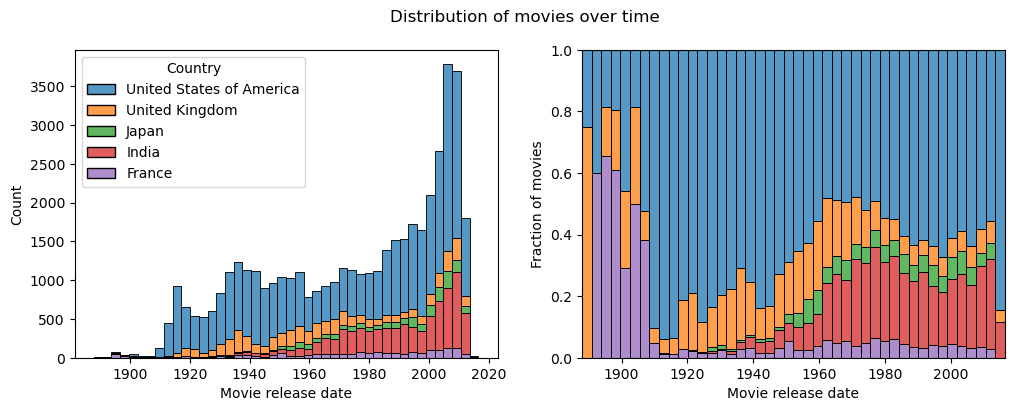

In [19]:
plot.movie_distribution_over_time(movies_parsed)

Based on this visualization we select movies from 1950 to 2013 for our analysis, and see that movies from each country are sufficiently represented.

C:\Users\Tim\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
C:\Users\Tim\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:264: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
C:\Users\Tim\anaconda3\envs\ada\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old b

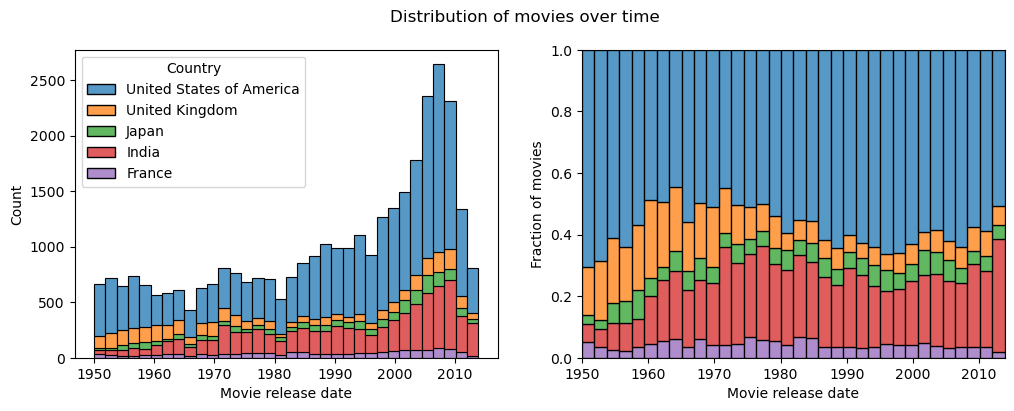

In [20]:
movies = clean.keep_dates(movies_parsed, 1950, 2013)
characters = clean.keep_dates(characters_parsed, 1950, 2013)
plot.movie_distribution_over_time(movies)

Add year and decade columns for convenient grouping.

In [21]:
clean.add_year_and_decade(movies)
clean.add_year_and_decade(characters)
summaries = clean.align_year_and_decade(summaries, characters)
movies[['Movie_Name', 'year', 'decade']].head(5)

,Movie_Name,year,decade
0,Ghosts of Mars,2001,2000
1,Ghosts of Mars,2001,2000
2,Ghosts of Mars,2001,2000
3,Ghosts of Mars,2001,2000
4,Ghosts of Mars,2001,2000


This leaves us with 40% of the original movies and 55% of the original actors.

In [22]:
ncountries = aggregate.ncountries(movies)
nmovies = aggregate.nmovies(movies)
nsummaries = aggregate.nmovies(summaries)
nactors = aggregate.nactors(characters)
print('Finished filtering dates:')
print(f'- Number of countries:  {ncountries:,} ({ncountries / ncountries_raw:.1%})')
print(f'- Number of movies:     {nmovies:,} ({nmovies / nmovies_raw:.1%})')
print(f'- Number of summaries:  {nsummaries:,} ({nsummaries / nsummaries_raw:.1%})')
print(f'- Number of actors:     {nactors:,} ({nactors / nactors_raw:.1%})')

Finished filtering dates:
- Number of countries:  5 (3.4%)
- Number of movies:     34,008 (41.6%)
- Number of summaries:  20,108 (47.5%)
- Number of actors:     74,133 (54.6%)


## 3. Initial analysis

We take a first look at the different features of our dataset and look for potential issues in the data.

### 3.1 Movie attributes

#### 3.1.1 Duration of a movie

Are movies from some countries shorter/longer than others?
To answer this question we take a look at the movie runtimes from our movie dataset, which are expressed in minutes.

Some movie runtimes are missing, these movies are dropped from analysis.

In [23]:
runtimes = features.runtimes(movies)
runtimes.head(5)

6,043 (17.8%) movies without runtime. Keeping 27,965 (82.2%) movies.


,Wikipedia_Movie_ID,Movie_Name,Movie_Runtime,Movie_Countries,decade
0,975900,Ghosts of Mars,98.0,United States of America,2000
7,3196793,Getting Away with Murder: The JonBenét Ramsey ...,95.0,United States of America,2000
11,9363483,White Of The Eye,110.0,United Kingdom,1980
27,2345652,City of the Dead,76.0,United Kingdom,1960
31,24229100,Lady Snowblood 2: Love Song of Vengeance,89.0,Japan,1970


Looking at the descriptive statistics of movie runtimes, we see that all runtimes are positive as expected, but in a range from 1 to 1,000,000 minutes.
We verify whether these are the actual runtime of the movies and filter erroneous data out. 

In [24]:
runtimes.Movie_Runtime.describe()

count    2.796500e+04
mean     1.380803e+02
std      6.453918e+03
min      1.000000e+00
25%      8.600000e+01
50%      9.500000e+01
75%      1.100000e+02
max      1.079281e+06
Name: Movie_Runtime, dtype: float64

We verified online whether some of the movies with "short runtime" (~1 min) was due to some error.
It seemed that most of these movies were indeed short films. 
Therefore, for the analysis, we decided to keep these movies with "short runtime". 

In [25]:
runtimes.sort_values(by='Movie_Runtime', ascending=True).head()

,Wikipedia_Movie_ID,Movie_Name,Movie_Runtime,Movie_Countries,decade
146436,74877,Let's All Go to the Lobby,1.0,United States of America,1950
3851,8692428,Mickey Mouse in Vietnam,1.0,United States of America,1960
20964,34313572,A Computer Animated Hand,1.0,United States of America,1970
179432,24193081,The Astounding Talent of Mr. Grenade,1.0,United States of America,2000
171566,5565476,Look at Life,1.0,United States of America,1960


We also verified some of the "super long" movies online. 
The runtime of most of these movies were also legitimate. 
However, for one movie (Zero Tolerance (Wikipedia_Movie_ID 10815585)), the runtime was exceedingly long. 
The runtime for Zero Tolerance as recorded in the dataset is 1079281 mins. 
However, according to Guinness world record (https://www.guinnessworldrecords.com/), the longest movies ever recorded is "The Cure of Insomnia". 
There were only two movies "Zero Tolerance" and "Cinematon" longer than "The cure of Insomnia". 
"Cinematon", according to Wikipedia was indeed longer than "The cure for Insomnia". 
But we couldn't find any reliable source to justify the runtime of "Zero Tolerance". 
Therefore, we decided to omit the data of "Zero Tolerance" for our analysis.

In [26]:
runtimes.sort_values(by='Movie_Runtime', ascending=False).head()

,Wikipedia_Movie_ID,Movie_Name,Movie_Runtime,Movie_Countries,decade
28342,10815585,Zero Tolerance,1079281.00,United States of America,1990
158505,25345684,Cinématon,9360.00,France,2010
103527,884435,The Cure for Insomnia,5220.00,United States of America,1980
60352,36136594,Kai Koduttha Dheivam,4875.27,India,1960
151902,884492,The Longest Most Meaningless Movie in the World,2880.00,United Kingdom,1960


Furthermore, looking at the distribution of movies, we see that anything above 300 minutes is an outlier.

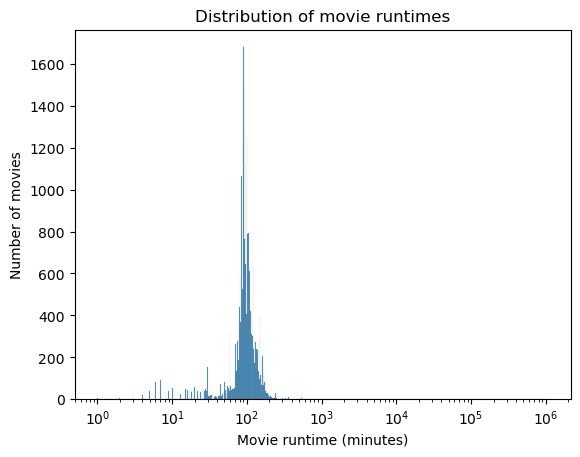

In [27]:
# Have to use log scale to properly see data
plot.runtime_distribution(runtimes, log=True)

Indeed, such durations are from experimental movies and are outliers, and will therefore be left out of the analysis to avoid skewing the data too much.
We now have a much cleaner distribution of movie runtimes.

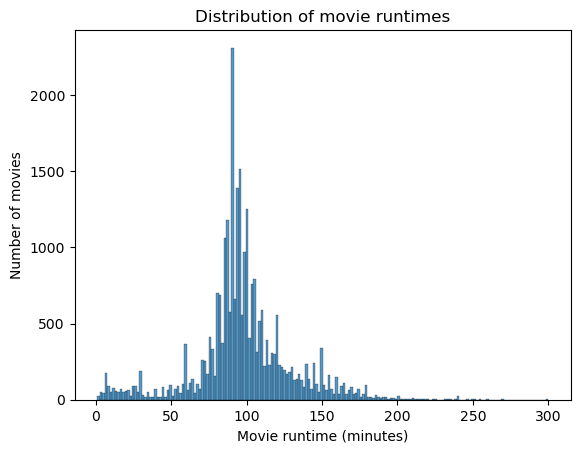

In [27]:
clean_runtimes = runtimes[runtimes.Movie_Runtime <= 300]
# Note that we do not need the log axis anymore!
plot.runtime_distribution(clean_runtimes, log=False)

After cleaning our runtimes, we create an initial visualization of the data to compare them between countries over time.
It seems that movies from all countries are relatively the same length, except for Indian movies which seem to be longer.
Over time duration from other countries seem to slightly increase while Indian movies seem to decrease.
Further analysis will use proper statistical tests to verify the significance of these observations.

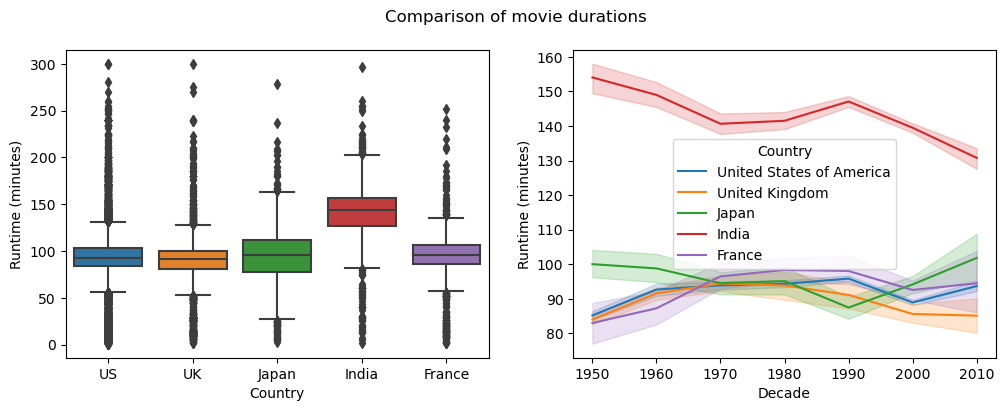

In [28]:
plot.runtime_comparison(clean_runtimes)

#### 3.1.2 Movie revenue

The revenue of majority of the movies are missing. It would have been interesting to get a realiable data source for the revenues. However, there would be various other cofounders making the analysis unreliable. One such example would be the inflation accross different countries overtime would be different which would impact the revenue of the movies. 

In [75]:
missing_revenues = aggregate.nmovies(movies[movies.Revenue.isna()])
print(f"We have {missing_revenues/nmovies:.1%} movies with missing revenue")

We have 83.8% movies with missing revenue


Because of the missing revenue (especially for Indian and Japanese movies) the values are a little all over the place.

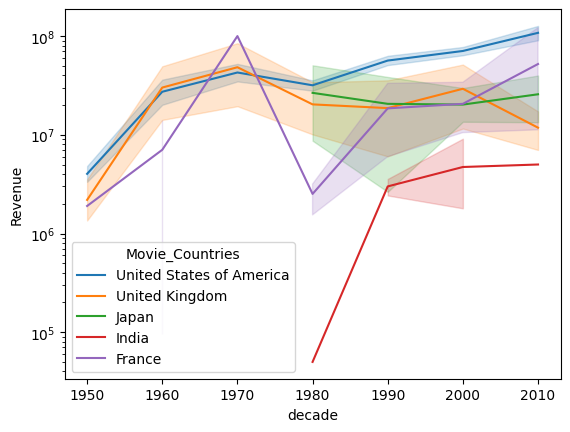

In [76]:
revenues = movies[['Wikipedia_Movie_ID', 'Revenue', 'Movie_Countries', 'decade']].drop_duplicates()
g = sns.lineplot(data=revenues, x='decade', y='Revenue', hue='Movie_Countries')
g.set_yscale('log')
plt.show()

#### 3.1.3 Budget

Since we don't have any data on budget, we will not do any analysis regarding the budget of the movies. 

#### 3.1.4 Movie genres

This will need some creativity as I'm not sure if the below visualization is the best.
Perhaps comparing the fraction of a genre relative to other genres within a country (within each period) would be more appropriate.
More experimenting is needed here!

<AxesSubplot: xlabel='Count', ylabel='Movie_Genres'>

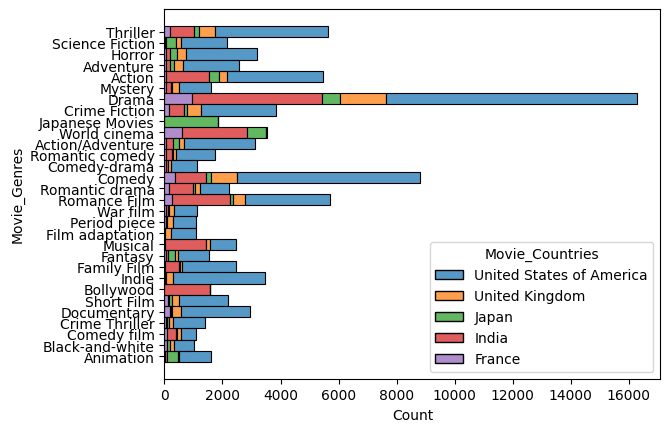

In [77]:
genres = movies[['Movie_Countries', 'Movie_Genres', 'decade']]
genres = genres.groupby(['Movie_Genres']).filter(lambda x: len(x) >= 1000)
sns.histplot(genres, y='Movie_Genres', hue='Movie_Countries', multiple='stack')

In [121]:
# get top 10 genres for each country
top_genres = movies[['Movie_Countries', 'Movie_Genres', 'decade']]
top_genres = top_genres.groupby(['Movie_Countries', 'Movie_Genres']).size().reset_index(name='counts')
top_genres = top_genres.sort_values(['Movie_Countries', 'counts'], ascending=[True, False])


In [122]:
top_genres.groupby('Movie_Countries').head(10)

,Movie_Countries,Movie_Genres,counts
59,France,Drama,953
172,France,World cinema,597
33,France,Comedy,378
137,France,Romance Film,272
164,France,Thriller,199
56,France,Documentary,181
48,France,Crime Fiction,172
139,France,Romantic drama,165
146,France,Short Film,121
35,France,Comedy film,79


Top 10 genres of each country

<AxesSubplot: xlabel='Count', ylabel='Movie_Genres'>

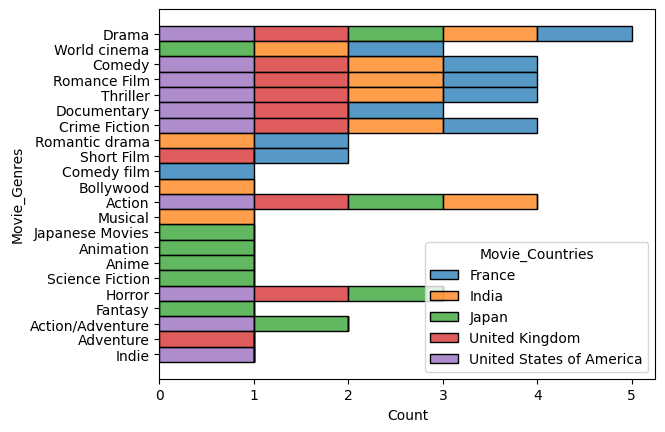

In [124]:
# plot top 10 genres for each country
top_genres = top_genres.groupby('Movie_Countries').head(10)
sns.histplot(top_genres, y='Movie_Genres', hue='Movie_Countries', multiple='stack')



#### 3.1.5 NLP insights


In [221]:
# read plot summaries
summaries_df = pd.read_csv('../data/MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['Wikipedia_Movie_ID', 'Plot_Summary'])

In [222]:
summaries_df.head(5)

,Wikipedia_Movie_ID,Plot_Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [223]:
# match wikipedia movie ids 
movies_sum = movies.merge(summaries_df, on='Wikipedia_Movie_ID', how='left')

In [227]:
movies_sum = movies_sum[["Movie_Name", "Movie_Countries", "Movie_Genres", "Movie_Runtime", "Revenue", "Plot_Summary"]].drop_duplicates()

In [247]:
movies_sum.dropna(subset=['Plot_Summary'], inplace=True)

In [248]:
len(movies_sum)

81171

In [249]:
# group summaries by genre and minmum number of char
summaries_gp = movies_sum.groupby(['Movie_Genres'])


In [250]:
summaries_gp.describe()

Movie_Runtime                                                \
                         count        mean           std   min    25%    50%   
Movie_Genres                                                                   
Absurdism                 59.0   94.067797     21.757174  30.0   86.0   91.0   
Acid western               4.0   90.750000      0.957427  90.0   90.0   90.5   
Action                  2954.0  473.248043  19855.815835   1.5   90.0  100.0   
Action Comedy             71.0   98.422535     18.761406   8.0   91.0   99.0   
Action Thrillers         249.0  104.220884     19.787057  57.0   91.0   99.0   
...                        ...         ...           ...   ...    ...    ...   
Workplace Comedy          61.0  100.196721     14.281479  77.0   89.0   98.0   
World History              4.0  176.000000    245.514426  40.0   55.0   60.0   
World cinema            2147.0  131.103891     49.699273  23.0  105.0  134.0   
Z movie                    2.0  100.000000     35.355339  75.0   87.5  100.0   
Zombie Film              137.0   87.116788     13.482050  17.0   84.0   89.0   

                                    Revenue                              \
                     75%        max   count          mean           std   
Movie_Genres                                                              
Absurdism          96.50      224.0    37.0  7.522848e+07  1.106102e+08   
Acid western       91.25       92.0     0.0           NaN           NaN   
Action            117.00  1079281.0  1087.0  8.928732e+07  1.629585e+08   
Action Comedy     105.00      146.0    52.0  8.209634e+07  1.145668e+08   
Action Thrillers  114.00      204.0   106.0  1.034876e+08  1.431546e+08   
...                  ...        ...     ...           ...           ...   
Workplace Comedy  107.00      144.0    33.0  6.846822e+07  9.527865e+07   
World History     181.00      544.0     0.0           NaN           NaN   
World cinema      151.00     1966.0    95.0  1.796960e+07  2.783484e+07   
Z movie           112.50      125.0     0.0           NaN           NaN   
Zombie Film        93.00      115.0    25.0  4.226876e+07  1.154155e+08   

                                                                    \
                        min          25%         50%           75%   
Movie_Genres                                                         
Absurdism          118192.0   7027290.00  36145695.0  9.925546e+07   
Acid western            NaN          NaN         NaN           NaN   
Action              13276.0   6008754.50  25819961.0  9.320364e+07   
Action Comedy     2500000.0  13447683.25  34597148.5  8.609358e+07   
Action Thrillers   199436.0  12609880.00  42307113.5  1.606968e+08   
...                     ...          ...         ...           ...   
Workplace Comedy   139084.0   7138523.00  26983776.0  9.057419e+07   
World History           NaN          NaN         NaN           NaN   
World cinema        24625.0   2376301.00   6548779.0  2.697482e+07   
Z movie                 NaN          NaN         NaN           NaN   
Zombie Film         54207.0   5364858.00  14182492.0  3.003939e+07   

                                
                           max  
Movie_Genres                    
Absurdism         5.814643e+08  
Acid western               NaN  
Action            1.511758e+09  
Action Comedy     6.243867e+08  
Action Thrillers  8.908716e+08  
...                        ...  
Workplace Comedy  3.741117e+08  
World History              NaN  
World cinema      2.026143e+08  
Z movie                    NaN  
Zombie Film       5.853490e+08  

[330 rows x 16 columns]

The all-MiniLM-L6 https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2] is a light model good to detect semantics

In [251]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [252]:
# print genres
for genre in summaries_gp.groups.keys():
    print(genre)

Absurdism
Acid western
Action
Action Comedy
Action Thrillers
Action/Adventure
Addiction Drama
Adult
Adventure
Adventure Comedy
Airplanes and airports
Albino bias
Alien Film
Alien invasion
Americana
Animal Picture
Animals
Animated Musical
Animated cartoon
Animation
Anime
Anthology
Anti-war
Anti-war film
Apocalyptic and post-apocalyptic fiction
Archaeology
Archives and records
Art film
Auto racing
Avant-garde
B-Western
B-movie
Backstage Musical
Baseball
Beach Film
Beach Party film
Bengali Cinema
Biker Film
Biographical film
Biography
Biopic [feature]
Black comedy
Black-and-white
Blaxploitation
Bloopers & Candid Camera
Bollywood
Boxing
Breakdance
British Empire Film
British New Wave
Buddy cop
Buddy film
Business
C-Movie
Camp
Caper story
Cavalry Film
Chase Movie
Chick flick
Childhood Drama
Children's
Children's Entertainment
Children's Fantasy
Children's Issues
Children's/Family
Christian film
Christmas movie
Cold War
Combat Films
Comedy
Comedy Thriller
Comedy Western
Comedy film
Comedy ho

In [254]:
%%time  
# encode action movies and romance movies
# perform the embedding only for one genre
action_embeddings = model.encode(summaries_gp.get_group('Action').Plot_Summary.tolist())
romance_embeddings = model.encode(summaries_gp.get_group('Romance Film').Plot_Summary.tolist())

CPU times: total: 32.6 s
Wall time: 15.2 s


In [255]:
# ploting tsne for action and romance movies
from sklearn.manifold import TSNE
random_state = 42
model_tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=random_state)

In [256]:
action_tsne = model_tsne.fit_transform(action_embeddings)
romance_tsne = model_tsne.fit_transform(romance_embeddings)

c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


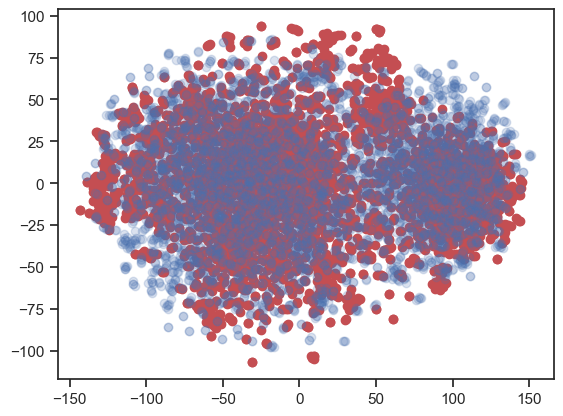

In [259]:
plt.scatter(action_tsne[:, 0], action_tsne[:, 1], c='r', label='Action')
plt.scatter(romance_tsne[:, 0], romance_tsne[:, 1], c='b', label='Romance', alpha=0.2)

We see an overlap between 2 genres plots on a symmantic level with some differences. A throughout analysis will be presented by P3 

We would like as well to determine the most significant x events. this is done by analyzing and studying the similarity between an event in a plot (sentence) and all the other remaing events happening.

In [265]:
movie_samples = movies_sum.sample(3, random_state=3)

In [266]:
movie_samples.head(3)

,Movie_Name,Movie_Countries,Movie_Genres,Movie_Runtime,Revenue,Plot_Summary
31096,Unbreakable,United States of America,Supernatural,107.0,248118121.0,Elijah Price is born with Type I osteogenesis...
19663,Pale Cocoon,Japan,Short Film,23.0,NaN,It has been many years since a group of humans...
63940,Talkin' Dirty After Dark,United States of America,Comedy,89.0,NaN,Stand up comedian Terry is a local funny man ...


In [270]:
# tokinize the plot summaries as sentences # a standard split would have been sufficient for these samples
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
movie_samples['Plot_Summary_sent'] = movie_samples['Plot_Summary'].apply(lambda x: sent_tokenize(x))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rayendhahri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [271]:
movie_samples.head(3)

,Movie_Name,Movie_Countries,Movie_Genres,Movie_Runtime,Revenue,Plot_Summary,Plot_Summary_sent
31096,Unbreakable,United States of America,Supernatural,107.0,248118121.0,Elijah Price is born with Type I osteogenesis...,[Elijah Price is born with Type I osteogenesi...
19663,Pale Cocoon,Japan,Short Film,23.0,NaN,It has been many years since a group of humans...,[It has been many years since a group of human...
63940,Talkin' Dirty After Dark,United States of America,Comedy,89.0,NaN,Stand up comedian Terry is a local funny man ...,[Stand up comedian Terry is a local funny man...


In [272]:
model_kps = SentenceTransformer("nlpaueb/bert-base-uncased-echr") # The warning is expected

No sentence-transformers model found with name C:\Users\rayendhahri/.cache\torch\sentence_transformers\nlpaueb_bert-base-uncased-echr. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\rayendhahri/.cache\torch\sentence_transformers\nlpaueb_bert-base-uncased-echr were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to

In [280]:
def gen_match_matrix(model, sents, min_match_score=0):
    """Generate a matrix of sentence matches for a list of sentences"""
    sents1 = [x for x in sents]
    sents1_embeddings = model.encode(sents1)
    sim_matrix = cosine_similarity(sents1_embeddings, sents1_embeddings)
    super_threshold_indices = sim_matrix < min_match_score
    sim_matrix[super_threshold_indices] = 0
    #print(sim_matrix)
    return sim_matrix

In [281]:
def filter_ranked_list(ranked_sents, model, min_match=0.8, N=3):
    """a ranked list of sentences is filtered by removing sentences that are too similar to other sentences in the list
    N is the number of sentences to return"""
    ranked_sents = [x[0] for x in ranked_sents]
    filtered_sents = []
    for i, s in enumerate(ranked_sents):
        if len(filtered_sents) >= N or len(filtered_sents) >= len(ranked_sents):
            break
        if len(filtered_sents) == 0:
            filtered_sents.append(s)
        else:
            matching_scores = gen_match_matrix(model, [s] + filtered_sents)
            max_sim = np.max(matching_scores[0][1:])
            # print(matching_scores)
            if max_sim < min_match:
                filtered_sents.append(s)
        
        # print(min_match)
    
    return filtered_sents

In [282]:
def apply_page_rank(sentences, p=0.85, min_match_score=0.5, min_len=5, max_len=35):
    """Apply page rank to a list of sentences
    min_match_score: minimum similarity score for two sentences to be considered similar
    min_len: minimum length of a sentence
    max_len: maximum length of a sentence
    returns a ranked list of sentences
    """
    cand_sents = [x for x in sentences if len(x.split()) < max_len and len(x.split()) > min_len]
    if len(cand_sents) == 0:
        #print('empty')
        return []
    # print(cands)
    # print(cands_qualities)
    cands_matching_mat = gen_match_matrix(model, cand_sents, min_match_score=min_match_score)
    pr = pagerank(cands_matching_mat, p=p)  # it looks like modifying the initial probability doesn't help
    # pr=pagerank(cands_matching_mat, p=p)
    ranked_candidates = list(zip(cand_sents, pr))
    return sorted(ranked_candidates, key=lambda x: -x[1])

In [291]:
# lets get 3 most influencial sentences for each movie
movie_samples["summary_kps"] = movie_samples["Plot_Summary_sent"].apply(lambda x: apply_page_rank(x, p=0.85, min_match_score=0.5, min_len=5, max_len=35))
movie_samples["summary_kps"] = movie_samples["summary_kps"].apply(lambda x: filter_ranked_list(x, model_kps, min_match=0.8, N=3))

c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\rayendhahri\anaconda3\envs\machine\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [293]:
# display the results full sentences
movie_samples[["Movie_Name", "summary_kps"]]


,Movie_Name,summary_kps
31096,Unbreakable,[David tries to console his son by saying that...
19663,Pale Cocoon,[It has been many years since a group of human...
63940,Talkin' Dirty After Dark,[He is struggling trying to make it at a local...


### 3.2 Diversity across industries

Possible metrics between countries:
- Age
- Gender ratio
- Ethnicity (although not much data, not sure if we can complete w/ other datasources)
- Actor height compared to national averages

This task should be similar to H1, just comparing populations using the appropriate statistic metrics.

Initial needed data wrangling:
- Age should be in the right range
- Gender ratio in an appropriate format for comparing
- Check if there is enough ethnicity data and if not try to obtain them from outside data source
- Obtain national heigh averages and compare them with appropriate methods

#### 3.2.1 Age

In [23]:
# assign to new variable
char_age = characters
characters.head()

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000


In [24]:
char_age.describe()

,index,Wikipedia_Movie_ID,Actor_Height,Actor_Age_at_Movie_Release,year,decade
count,244681.000000,2.446810e+05,100825.000000,179121.000000,244681.000000,244681.000000
mean,148160.714661,1.265739e+07,1.769042,38.487319,1990.977603,1986.419501
std,85665.407806,1.056337e+07,2.885711,23.652003,17.486817,17.522796
min,0.000000,3.217000e+03,0.813000,-7896.000000,1950.000000,1950.000000
25%,73923.000000,3.076631e+06,1.680000,28.000000,1979.000000,1970.000000
50%,148000.000000,9.652328e+06,1.750000,37.000000,1996.000000,1990.000000
75%,222682.000000,2.168464e+07,1.830000,48.000000,2006.000000,2000.000000
max,296570.000000,3.750192e+07,510.000000,103.000000,2013.000000,2010.000000


There are still some inconsistencies in age which have to be filtered out. Data with negative age and NaN value will be removed.

In [25]:
# data with errors
char_age[char_age.Actor_Age_at_Movie_Release < 0].head()

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
6928,6948,31163724,United States of America,/m/0gdk5td,1956-01-01,NaN,1973,M,NaN,NaN,Eric Chase Anderson,-17.0,/m/0gdljss,NaN,/m/026xg0t,1956,1950
8910,8933,21242801,United States of America,/m/05bzjwj,1955-08-07,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0,1955,1950
13154,13184,20019382,United States of America,/m/04y9xhm,1977-09-28,El Raheem,2004-01-13,M,NaN,NaN,Don Blakely,-26.0,/m/0cgrzfq,/m/0cgrzft,/m/0bhh1hn,1977,1970
21739,21795,5261848,United States of America,/m/0dbfw4,1988-01-24,NaN,1992-10-19,NaN,NaN,NaN,Perry Allen,-4.0,/m/06mg50n,NaN,/m/06mg50r,1988,1980
23138,23194,11143228,India,/m/02r1gz2,1976-01-01,NaN,1982,F,NaN,NaN,Vijayalakshmi Agathiyan,-6.0,/m/0kn359c,NaN,/m/04gltqm,1976,1970


This is the data without missing/wrong data about the actor's age:

In [26]:
# clean dataframe
clean.positive_age(char_age)

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295974,296563,913762,Japan,/m/03pcrp,1992-05-21,Lord Feff,1960-04-28,M,NaN,NaN,Steven Blum,32.0,/m/0kr408g,/m/0kr408l,/m/044_7j,1992,1990
295976,296565,913762,Japan,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz,1992,1990
295977,296566,913762,Japan,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1992,1990
295978,296567,913762,Japan,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1992,1990


For some characters age is missing but can be calculated with DOB and Release Date of the movie. Even in the Actor_DOB column exist inconsistencies, as the supposed actor was born in 1498 and took part in a movie almost 300 years later:

In [27]:
# characters with dob (date of birth) and mrd (movie release date) but not age at movie release
dob_mrd_char = load.release_birth_date(char_age)
dob_mrd_char[pd.to_datetime(dob_mrd_char.Actor_DOB, format='%Y/%m/%d', errors='coerce').isnull()]

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
2457,2464,21038272,India,/m/05b268g,1979-01-01,NaN,1498,F,NaN,NaN,Mirabai,NaN,/m/05cnn3x,NaN,/m/03h165,1979,1970
120931,121161,20072112,United States of America,/m/04n46f5,2008-01-01,NaN,1075-08-19,F,NaN,NaN,Holly Eglington,NaN,/m/0gc7_rh,NaN,/m/0gc64t0,2008,2000


In [28]:
# drop these rows
char_age, removed_idx = clean.date_range(dob_mrd_char, char_age)
char_age

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295977,296566,913762,Japan,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1992,1990
295978,296567,913762,Japan,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1992,1990
295979,296568,913762,Japan,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h,1992,1990
295980,296569,913762,Japan,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1992,1990


In [29]:
# convert into date format to extract year
dob_mrd_char = clean.parse_dates(dob_mrd_char, 'Actor_DOB')
dob_mrd_char = clean.parse_dates(dob_mrd_char, 'Movie_Release_Date')
dob_mrd_char

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
85,85,77856,United States of America,/m/0kcn7,1964-08-27,The Constable,1894-07-23 00:00:00,M,NaN,NaN,Arthur Treacher,NaN,/m/0cg2t2_,/m/0h5njw9,/m/020csj,1964,1960
87,87,77856,United States of America,/m/0kcn7,1964-08-27,Uncle Albert,1886-11-09 00:00:00,M,1.8200,NaN,Ed Wynn,NaN,/m/05nn480,/m/05ysxy5,/m/01k67w,1964,1960
91,91,77856,United States of America,/m/0kcn7,1964-08-27,Admiral Boom,1887-08-05 00:00:00,M,NaN,NaN,Reginald Owen,NaN,/m/0csl6kq,/m/0h5njw2,/m/0b47ns,1964,1960
280,280,5915856,India,/m/0fdc85,2003-10-01,NaN,1970-09-09 00:00:00,M,NaN,NaN,Biju Menon,NaN,/m/0j_1kz,NaN,/m/0g9d5d,2003,2000
281,281,5915856,India,/m/0fdc85,2003-10-01,NaN,1965-12-10 00:00:00,M,NaN,NaN,Jayaram,NaN,/m/0j_1kn,NaN,/m/075p0r,2003,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295532,296120,25431214,India,/m/09k5h57,2009-12-01,Mathews,1960-05-21 00:00:00,M,1.7200,/m/0dryh9k,Mohanlal,NaN,/m/0gvzwgy,/m/0h1j8l9,/m/02fbpz,2009,2000
295533,296121,25431214,India,/m/09k5h57,2009-12-01,Adv. Sunitha,1989-05-05 00:00:00,F,1.7018,/m/074w_m,Lakshmi Rai,NaN,/m/0gvz_3b,/m/0h34ydz,/m/02pnknk,2009,2000
295534,296122,25431214,India,/m/09k5h57,2009-12-01,Adv. Prabalan,1956-04-06 00:00:00,M,NaN,/m/046cwm,Sreenivasan,NaN,/m/0hh977l,/m/0hh977p,/m/05gc0h,2009,2000
295535,296123,25431214,India,/m/09k5h57,2009-12-01,NaN,1985-06-30 00:00:00,F,NaN,NaN,Priyanka Nair,NaN,/m/0n9_2kr,NaN,/m/0czbskd,2009,2000


The age of the actors are based on the year of birth and year of movie release as the data does not provide a consistent format including day and month dates for all subjects.

In [30]:
# replace the actors' calculated ages and remove the wrong data
# replace NaN with calculated age in original dataframe
char_age = clean.calc_age(dob_mrd_char, char_age, removed_idx)

C:\Users\Tim\OneDrive\Studium M. Sc\EPFL\ADA\ada-2022-project-robopros\notebooks\../src\clean.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Actor_Age_at_Movie_Release.loc[df1.index] = df1.Actor_Age_at_Movie_Release


In [31]:
# cleansed data
char_age = clean.positive_age(char_age)
char_age

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Gender,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295976,296565,913762,Japan,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz,1992,1990
295977,296566,913762,Japan,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,1992,1990
295978,296567,913762,Japan,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd,1992,1990
295980,296569,913762,Japan,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,22.0,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1992,1990


There are still some outliers as some movies include retrospectives on older movies with the same character (especially animation movies). This data is not representative for our analysis and will be filtered out as well. According to Roser et al. the life expectancy in the chosen countries was around 80 years in 2005. We will therefore set a threshold at 90 years to account for the increase in life expectancy with improved healthcare and some possible outliers.

Source: https://ourworldindata.org/life-expectancy

<AxesSubplot: title={'center': 'Actor_Age_at_Movie_Release'}, xlabel='Movie_Countries'>

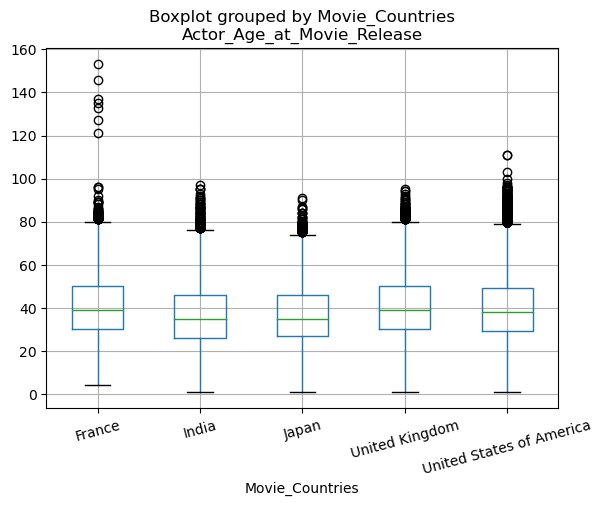

In [32]:
# plot data to check for further inconsistencies
char_age.boxplot(by='Movie_Countries', column='Actor_Age_at_Movie_Release', rot=15)

In [33]:
# filter out errors
char_age = char_age[char_age.Actor_Age_at_Movie_Release < 90]

For 25.7 % of the given actors we can analyze the age distribution:

In [34]:
nactors_age = aggregate.nactors(char_age)
print(f'- Number of actors:     {nactors_age} ({nactors_age / nactors_raw:.1%})')

- Number of actors:     34892 (25.7%)


#### 3.2.2 Gender

In [35]:
# assign to new variable
char_gender = characters

In [36]:
no_nan_gender = len(char_gender[char_gender.Actor_Gender.isna()])
print(f"There are {no_nan_gender} NaN values for the gender of actors.")

There are 20869 NaN values for the gender of actors.


In [37]:
# drop missing data
char_gender = char_gender.dropna(subset='Actor_Gender')

For 41.1 % of the given actors we can analyze the gender ratio:

In [38]:
nactors_gender = aggregate.nactors(char_gender)
print(f'- Number of actors:     {nactors_gender} ({nactors_gender / nactors_raw:.1%})')

- Number of actors:     55770 (41.1%)


In general the number of female actors in movies was much less than the number of male actors. Is the movie industry really male dominated or did it change over time?

In [39]:
# compare male and female in different countries
char_gender.groupby(['Actor_Gender', 'Movie_Countries'])['Actor_Gender'].count()

Actor_Gender  Movie_Countries         
F             France                       2391
              India                       14411
              Japan                        3385
              United Kingdom               6254
              United States of America    48165
M             France                       3746
              India                       27816
              Japan                        5514
              United Kingdom              13469
              United States of America    98661
Name: Actor_Gender, dtype: int64

[Text(0.5, 1.0, 'Gender distribution in the Big 5 Movie Industries')]

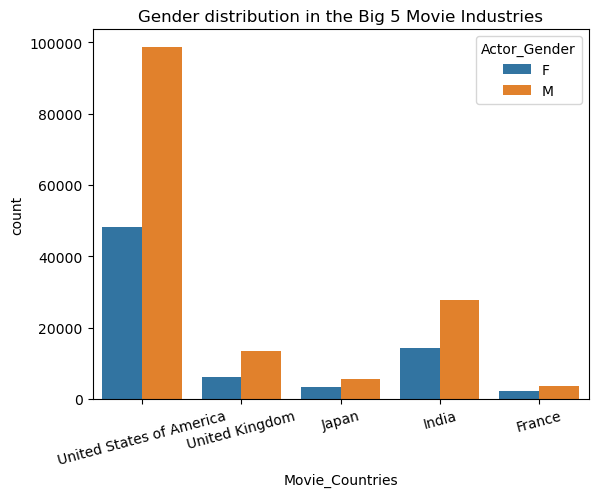

In [40]:
# plot data
gender_plot = sns.countplot(data=char_gender, x='Movie_Countries', hue='Actor_Gender')
gender_plot.set_xticklabels(gender_plot.get_xticklabels(), rotation=15)
gender_plot.set(title='Gender distribution in the Big 5 Movie Industries')

In [41]:
# split the data into two columns and creating indicator variables for Male and Female
char_gender = pd.get_dummies(char_gender, columns=['Actor_Gender'])
char_gender.head()

,index,Wikipedia_Movie_ID,Movie_Countries,Freebase_Movie_ID,Movie_Release_Date,Character_Name,Actor_DOB,Actor_Height,Actor_Ethnicity,Actor_Name,Actor_Age_at_Movie_Release,Freebase_Char_Actor_Map_ID,Freebase_Char_ID,Freebase_Actor_ID,year,decade,Actor_Gender_F,Actor_Gender_M
0,0,975900,United States of America,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,2000,1,0
1,1,975900,United States of America,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,2000,1,0
2,2,975900,United States of America,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,2000,0,1
3,3,975900,United States of America,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001,2000,0,1
4,4,975900,United States of America,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001,2000,1,0


In [42]:
# calculate female/male ratio for decades
# create new dataframe
df_gender_ratio = load.gender_ratio(char_gender)

[Text(0.5, 1.0, 'Gender Ratio over Decades in different Countries')]

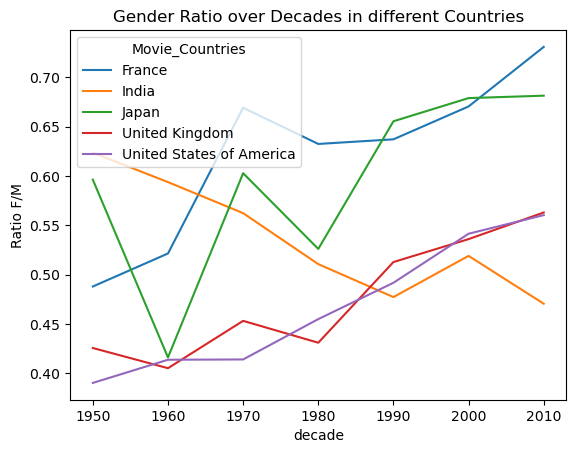

In [43]:
# plot new dataframe
g = sns.lineplot(data=df_gender_ratio, x='decade', y='Ratio F/M', hue='Movie_Countries')
g.set(title='Gender Ratio over Decades in different Countries')

#### 3.2.3 Ethnicity

In [44]:
# assign new variable
char_ethnicity = characters

In [45]:
no_nan_ethnicity = len(char_ethnicity[char_ethnicity.Actor_Ethnicity.isna()])
print(f"There are {no_nan_ethnicity} NaN values for the ethnicity of actors.")

There are 173240 NaN values for the ethnicity of actors.


In [46]:
# drop rows with missing values
char_ethnicity = char_ethnicity.dropna(subset='Actor_Ethnicity')

For 5 % of the given actors we can analyze the ethnicity:

In [47]:
nactors_ethn = aggregate.nactors(char_ethnicity)
print(f'- Number of actors:     {nactors_ethn} ({nactors_ethn / nactors_raw:.1%})')

- Number of actors:     6777 (5.0%)


Since there are so many different ethnicities but not much data about actors' ehtnicities, we try to measure the diversity by how many different ethnicities a country's movie industry has.

Furtheremore, the ethnicity is encoded by Freebase IDs. We therefore use Wikidata Query Service (Wikipedia) to get all the Freebase IDs with the corresponding ethnicity. The Freebase IDs can then be assigned to ethnicity names.

The query given to the Wikidata Query Service was:

In [ ]:
# SPARQL code to match wikidata
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>

SELECT DISTINCT ?item ?itemLabel ?freebaseID WHERE {
  ?item p:P646 [ps:P646 ?freebaseID].
  VALUES ?freebaseID {query} # query contains all the freebase IDs
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}

In [48]:
# get the Freebase IDs and save them in a txt
FB_ID_TXT = '../data/fb_ids.txt'

with open(FB_ID_TXT, 'w') as f:
    for fb_id in char_ethnicity.Actor_Ethnicity.unique():
        f.write('"' + fb_id + '" ')

The output was downloaded as a JSON file and will be used for the assignments.

In [49]:
# load json file
FB_ETHNICITY_ASSIGNMENTS = '../data/query.json'

f = open(FB_ETHNICITY_ASSIGNMENTS)
freebase_ethnicity = json.load(f)
f.close()

In [50]:
# create mapping dictionary for Freebase to ethnicity name and replace value
char_ethnicity = clean.get_ethnicities(char_ethnicity, freebase_ethnicity)

There still exist Freebase IDs which couldn't be assigned as wikidata didn't find a corresponding name.

In [51]:
# get ids which couldn't be assigned
not_found_ethn = aggregate.not_assigned_fb_ids(char_ethnicity)        
print(f"There are {len(not_found_ethn)} IDs which couldn't be assigned.")

There are 41 IDs which couldn't be assigned.


In [52]:
unique_ethn = len(char_ethnicity.Actor_Ethnicity.unique())
print(f'There are {unique_ethn} different ethnicities in the dataset.')

There are 418 different ethnicities in the dataset.


In [53]:
# create dataframe containing the number of different ethnicities per country and decade
count_ethnic = aggregate.ethnicities_country(char_ethnicity)

The number of different ethnicities has risen over the decades. Since we only have data until 2013, the decade of 2010's is underpresented and therefore lower than the 2000's.

<AxesSubplot: title={'center': 'Number of Different Ethnicities over Decades in the Big 5'}, xlabel='Movie_Countries'>

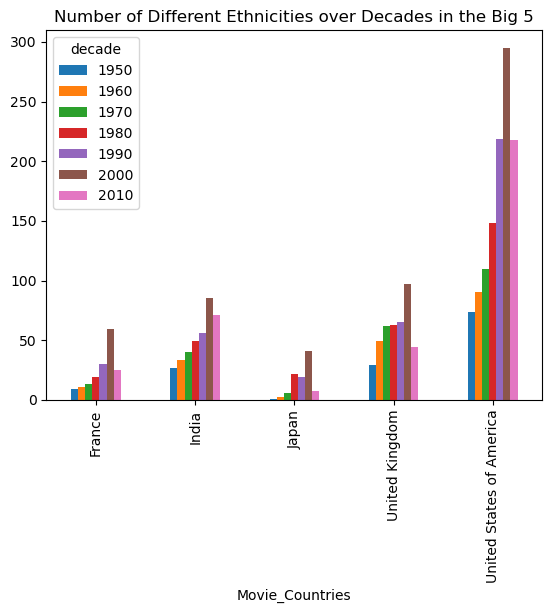

In [54]:
# plot number of ethnicities
count_ethnic.unstack().plot(kind='bar', title='Number of Different Ethnicities over Decades in the Big 5')

As we have more data about the US they also have more different ethnicities in total. We will therefore get a ratio.

In [55]:
# ratio number of unique / number of actors
ratio_u_t = load.ethnicity_ratio(char_ethnicity)

<AxesSubplot: title={'center': 'Ratio of Different Ethnicities Over Number of Actors in the Big 5'}, xlabel='Movie_Countries'>

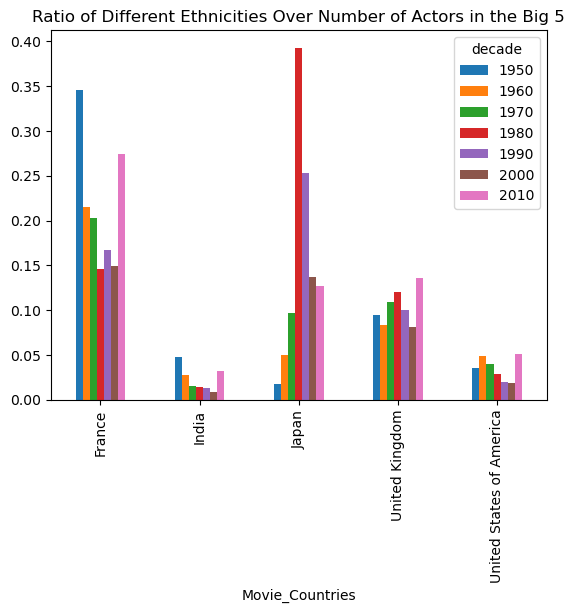

In [56]:
ratio_u_t.unstack().plot(kind='bar', title='Ratio of Different Ethnicities Over Number of Actors in the Big 5')

As in Asian countries the most representative ethnic group is supposedly Asians, we will examine the strongest ethnic groups in the countries.

As can be seen, there are still some inconsistencies in the assignment of ethnicities. There are e.g. 'white people' but also nationalities given, like 'French' or 'Italians'. Or 'Japanese people' but also 'Asian people' which should be a more abstract expression containing all ethnicities from Asia. This has to be accounted for when working with ethnicities.

In [57]:
# get the top 5 ethnicities from each of the big 5 movie industries
top_ethn = load.top_n_ethnic(char_ethnicity, n=5)
top_ethn

Count
Movie_Countries          Actor_Ethnicity         
France                   French               534
                         Jewish people         65
                         white people          30
                         Italians              27
                         /m/02p656s            22
India                    Indians            13822
                         Tamil               1007
                         Punjabis             939
                         Malayali             884
                         Marathi people       744
Japan                    Japanese people      476
                         Jewish people         19
                         Asian people          18
                         English people         9
                         African Americans      8
United Kingdom           English people      1592
                         Jewish people        417
                         British people       359
                         Scottish people      262
                         White British        242
United States of America African Americans   7969
                         Jewish people       6398
                         Irish Americans     2638
                         Italian Americans   2273
                         white Americans     1700

In [58]:
# get the total number of actors with data about information grouped by country
total_number = char_ethnicity.groupby('Movie_Countries').Actor_Ethnicity\
.count().to_frame().rename(columns={'Actor_Ethnicity': 'Count'})

In [59]:
# percentage / ratio
top_perc = top_ethn.div(total_number).rename(columns={'Count': 'Fraction'})

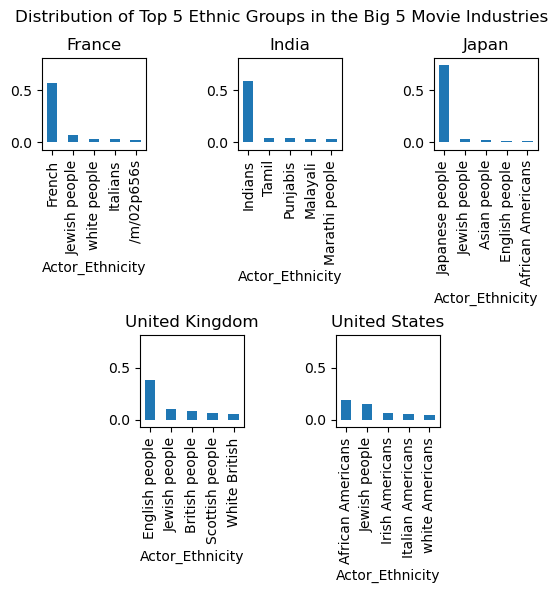

In [60]:
# plot Distribution of Top 5 Ethnic Groups in the Big 5 Movie Industries
plot.ethnic_ratio_countries(top_perc)

#### 3.2.4 Height

In [61]:
# assign to new variable
char_height = characters

In [62]:
no_nan_height = len(char_height[char_height.Actor_Height.isna()])
print(f"There are {no_nan_height} NaN values for the height of actors.")

There are 143856 NaN values for the height of actors.


In [63]:
# drop rows with missing values
char_height = char_height.dropna(subset='Actor_Height')

The maximum height of 510 m is impossible, therefore, there exist inconsistent data about the actor's height. The tallest person was 2.72 m. Therefore, we will filter out every actor above that height.

Source: https://en.wikipedia.org/wiki/Robert_Wadlow

In [64]:
# check statistics for inconsistencies
char_height.Actor_Height.describe()

count    100825.000000
mean          1.769042
std           2.885711
min           0.813000
25%           1.680000
50%           1.750000
75%           1.830000
max         510.000000
Name: Actor_Height, dtype: float64

In [65]:
# filter data
char_height = char_height[char_height.Actor_Height < 2.72]

For 8.1 % of the given actors we can analyze the height:

In [66]:
nactors_height = aggregate.nactors(char_height)
print(f'- Number of actors:     {nactors_height} ({nactors_height / nactors_raw:.1%})')

- Number of actors:     10975 (8.1%)


<AxesSubplot: title={'center': 'Actor_Height'}, xlabel='Movie_Countries'>

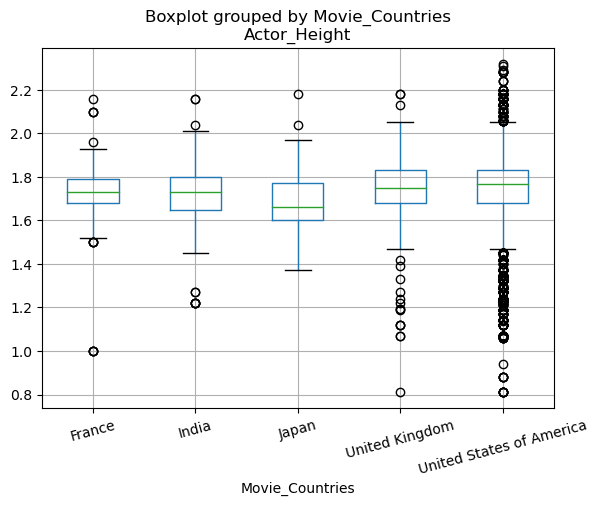

In [67]:
# plot data
char_height.boxplot(by='Movie_Countries', column='Actor_Height', rot=15)

C:\Users\Tim\AppData\Local\Temp\ipykernel_26952\1790738641.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=char_height, x="decade", y="Actor_Height", hue="Movie_Countries", ci=95)


<AxesSubplot: xlabel='decade', ylabel='Actor_Height'>

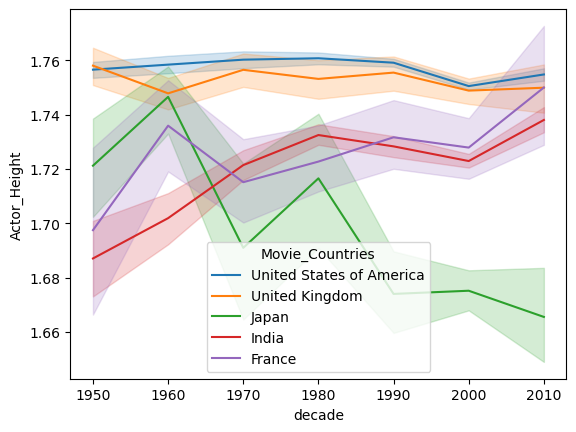

In [68]:
# check height over decades
# CI of 95 % was added
sns.lineplot(data=char_height, x="decade", y="Actor_Height", hue="Movie_Countries", ci=95)

As women are generally less tall than men, we will split the data into male and female.

In [69]:
# use gender as additional information
# assign data to male/female
female_height, male_height = load.indicator_mf(char_height)

To check for discrimination we need to compare the smallest and tallest persons during the decades. The average value does not give much information about that.

In [70]:
female_height.Actor_Height.describe()

count    36376.000000
mean         1.661554
std          0.068711
min          1.060000
25%          1.620000
50%          1.660000
75%          1.702000
max          2.010000
Name: Actor_Height, dtype: float64

In [71]:
male_height.Actor_Height.describe()

count    64349.000000
mean         1.800644
std          0.088822
min          0.813000
25%          1.750000
50%          1.800000
75%          1.850000
max          2.316480
Name: Actor_Height, dtype: float64

In [72]:
# get the min and max values
min_max_mh = aggregate.max_min(male_height)
min_max_fh = aggregate.max_min(female_height)

The UK and the USA had both very tall and short male actors over the time of 1950-2013. France and India started including very short male actors from the 2000's. Tall people were always part of movies, however, short men were not included in Japan. Short-grown women were not part of movies until the 80's.

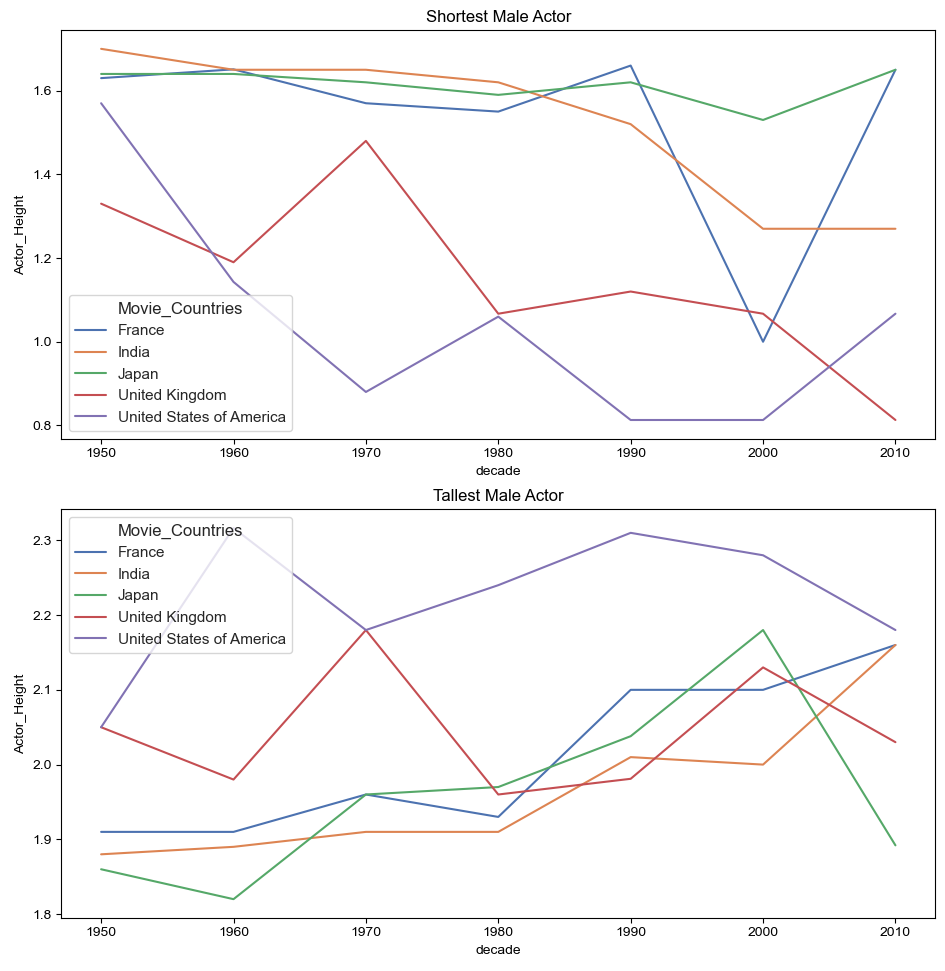

In [73]:
# check male height over decades
plot.height_decades(min_max_mh, 'Male')

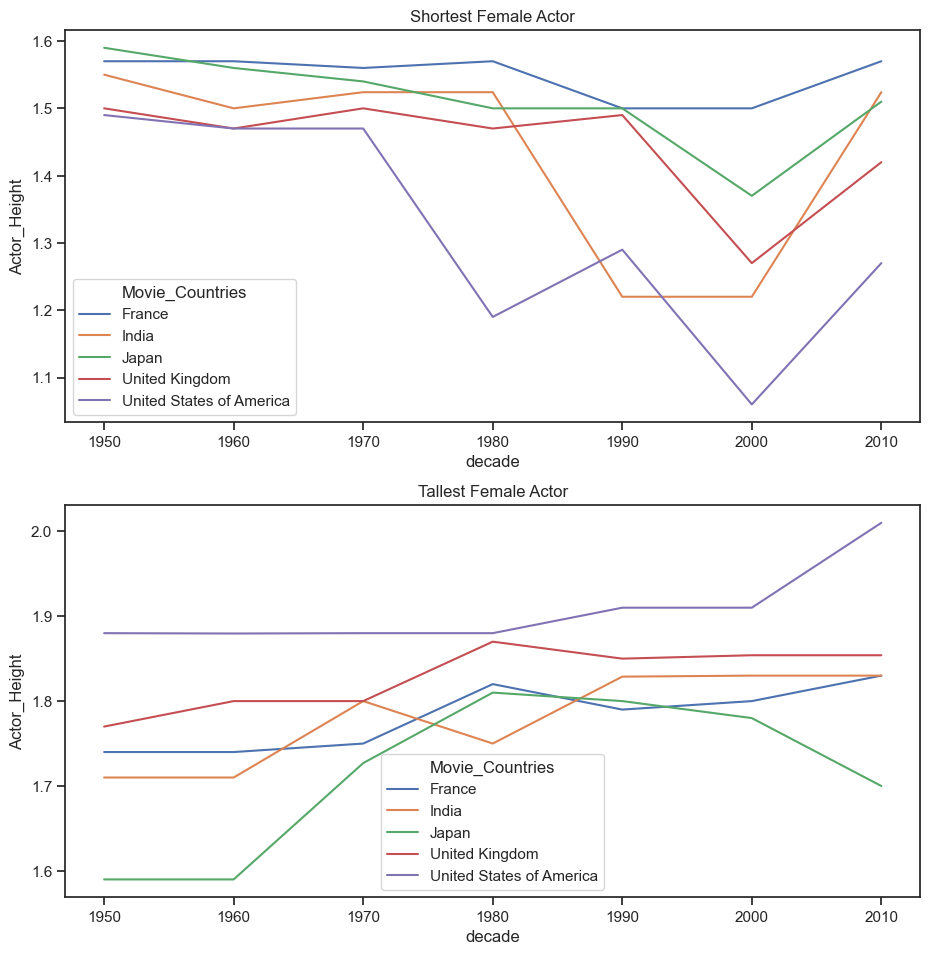

In [74]:
# check female height over decades
plot.height_decades(min_max_fh, 'Female')

### 3.3 Success across industries

Our intial question, but now more precisely comparing across different countries.
What factors predict the success of a movie (financial and rating), and do they differ across the different countries?

We are interested in collecting other metadata to support our analysis. For this we harverst the imdb rating and we use for that imdb python api that seem to be more native and easier than through requests as the html location differ. The initial steps for how to perform it with beautiful soup will be as well showcased. 


In [142]:
# sample data where there is 10 movies for each country and decade
sample = movies.groupby(['Movie_Countries', 'decade']).apply(lambda x: x.sample(10))
#sample_movies = movies[['Movie_Name', 'Movie_Runtime', 'Movie_Countries', 'decade']].drop_duplicates().sample(100)

In [146]:
def get_rating(movie_name):
    """Get the rating of a movie from IMDB"""	
    # get the rating of a movie
    imdb_obj = imdb.IMDb()
    print(f"Searching for {movie_name}...")
    search = imdb_obj.search_movie(movie_name)  # search for the movie name in the imdb database 
    if len(search) == 0:
        print(f"Movie {movie_name} not found.")
        return None
    else:
        movie_id = search[0].getID()  # get the id of the first result
        imdb_url = 'http://www.imdb.com//title/tt'+ movie_id +'/' # create the url
        #response = requests.get(imdb_url) # get the response
        #soup = BeautifulSoup(response.text, "html.parser") # parse the response but it is easier to harvest the data using the api
        movie_meta = imdb_obj.get_movie(movie_id)
        if 'rating' in movie_meta.keys():
            rating = movie_meta['rating']
            print(f"Rating of {movie_name} is {rating}")
            return rating
        else:
            print(f"Rating of {movie_name} not found.")
            return None

In [147]:
# get the rating of the movies in the sample
sample['rating'] = sample.Movie_Name.apply(get_rating)

Searching for Two Men in Manhattan...
Rating of Two Men in Manhattan is 6.6
Searching for Night and Fog...
Movie Night and Fog not found.
Searching for Diary of a Country Priest...
Rating of Diary of a Country Priest is 7.8
Searching for Manèges...
Rating of Manèges is 7.2
Searching for Massacre in Lace...
Movie Massacre in Lace not found.
Searching for Casque d'or...
Rating of Casque d'or is 7.6
Searching for Afrique 50...
Rating of Afrique 50 is 7.2
Searching for Cyrano de Bergerac...
Rating of Cyrano de Bergerac is 7.5
Searching for La Ronde...
Movie La Ronde not found.
Searching for La Marie du port...
Movie La Marie du port not found.
Searching for The Smugglers...
Rating of The Smugglers is 6.2
Searching for Two or Three Things I Know About Her...
Movie Two or Three Things I Know About Her not found.
Searching for The Two of Us...
Rating of The Two of Us is 6.5
Searching for The Sleeping Car Murders...
Movie The Sleeping Car Murders not found.
Searching for La Jetée...
Movie La J

In [148]:
sample.head(10)

index  Wikipedia_Movie_ID Freebase_Movie_ID  \
Movie_Countries decade                                                       
France          1950   62702   28136            20789377        /m/057ch2s   
                       125394  56424            20181860         /m/017js3   
                       138110  62020            29831417         /m/086pyj   
                       78613   35415            28126186        /m/0cm9vqf   
                       155544  69735            29002980        /m/0dgq9xq   
                       6567     2986             3654133         /m/09sg_s   
                       5336     2435            35002603        /m/0j62n_g   
                       153357  68788             4432750         /m/0c22kf   
                       176492  78978             1923722         /m/066fb9   
                       129379  58156            25289332        /m/09gcybf   

                                              Movie_Name Movie_Release_Date  \
Movie_Countries decade                                                        
France          1950   62702        Two Men in Manhattan         1959-10-16   
                       125394              Night and Fog         1955-01-01   
                       138110  Diary of a Country Priest         1951-01-01   
                       78613                     Manèges         1950-01-25   
                       155544           Massacre in Lace         1952-03-12   
                       6567                  Casque d'or         1952-04-16   
                       5336                   Afrique 50         1950-01-01   
                       153357         Cyrano de Bergerac         1950-01-01   
                       176492                   La Ronde         1950-01-01   
                       129379           La Marie du port         1950-02-25   

                                 Revenue  Movie_Runtime   Movie_Languages  \
Movie_Countries decade                                                      
France          1950   62702         NaN           84.0   French Language   
                       125394        NaN           32.0   French Language   
                       138110        NaN          115.0   French Language   
                       78613         NaN           91.0   French Language   
                       155544        NaN           97.0   French Language   
                       6567          NaN           94.0   French Language   
                       5336          NaN           17.0   French Language   
                       153357  1900000.0          112.0  English Language   
                       176492        NaN           93.0   French Language   
                       129379        NaN          100.0   French Language   

                              Movie_Countries    Movie_Genres  year  decade  \
Movie_Countries decade                                                        
France          1950   62702           France        Thriller  1959    1950   
                       125394          France      Short Film  1955    1950   
                       138110          France         Mystery  1951    1950   
                       78613           France       Melodrama  1950    1950   
                       155544          France   Crime Fiction  1952    1950   
                       6567            France           Drama  1952    1950   
                       5336            France      Short Film  1950    1950   
                       153357          France           Drama  1950    1950   
                       176492          France  Romantic drama  1950    1950   
                       129379          France    Romance Film  1950    1950   

                               rating  
Movie_Countries decade                 
France          1950   62702      6.6  
                       125394     NaN  
                       138110     7.8  
                       78613      7.2  
                       155544  

In [155]:
# drop rows with missing values
sample = sample.dropna(subset=['rating'])


In [160]:
sample.describe()

,index,Wikipedia_Movie_ID,Revenue,Movie_Runtime,year,decade,rating
count,170.000000,1.700000e+02,2.200000e+01,146.000000,170.000000,170.000000,170.000000
mean,45324.311765,1.574861e+07,6.785821e+07,107.691781,1985.129412,1981.000000,6.410588
std,24391.698488,1.154283e+07,1.585666e+08,37.721039,19.776436,20.341755,1.133359
min,390.000000,1.792000e+04,1.900000e+06,17.000000,1950.000000,1950.000000,3.300000
25%,24072.000000,4.575240e+06,7.319495e+06,90.000000,1969.000000,1960.000000,5.700000
50%,51617.500000,1.486190e+07,2.254856e+07,102.000000,1987.000000,1980.000000,6.500000
75%,65159.750000,2.625152e+07,4.700489e+07,122.000000,2004.000000,2000.000000,7.200000
max,81306.000000,3.669992e+07,7.522166e+08,360.000000,2013.000000,2010.000000,8.600000


<AxesSubplot: >

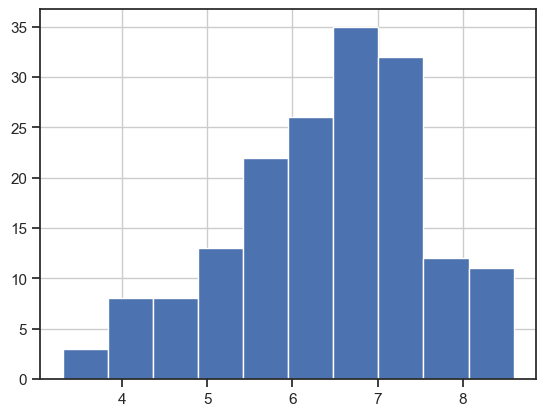

In [159]:
sample.rating.hist()

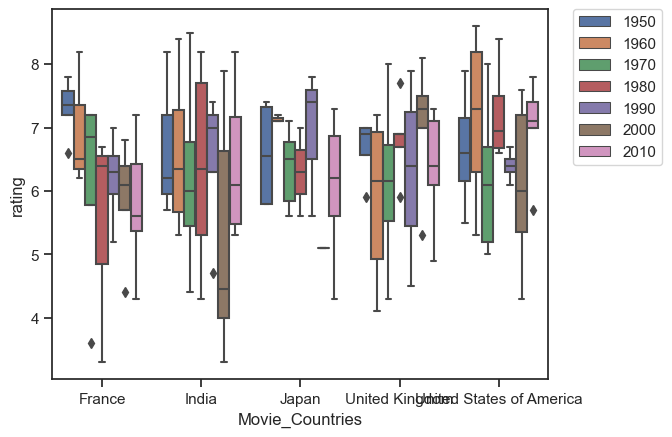

In [165]:
# plot data for specific countries
sns.boxplot(data=sample, x="Movie_Countries", y="rating", hue="decade")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


<AxesSubplot: xlabel='decade', ylabel='rating'>

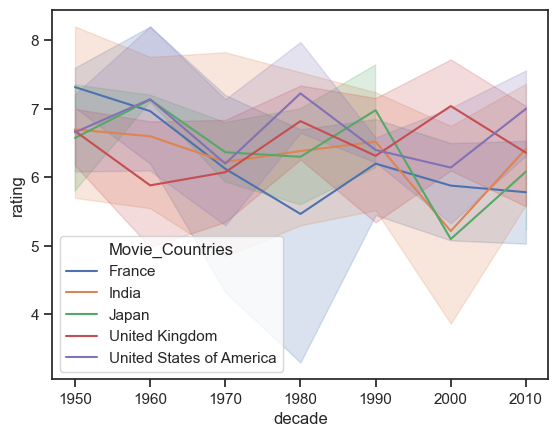

In [169]:
# plot rating over decades
sns.lineplot(data=sample, x="decade", y="rating", hue="Movie_Countries")

## 4. Full Analysis

### 4.2 Diversity

#### Further Analysis

##### 4.1 Age

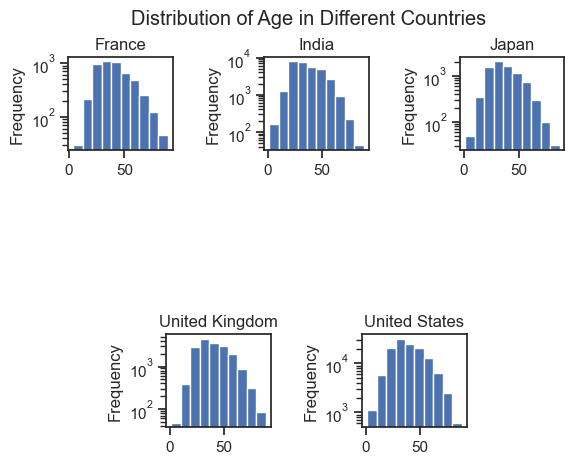

In [75]:
# Histogram Age
plot.distributions_countries(char_age, 'Actor_Age_at_Movie_Release', "Distribution of Age in Different Countries", logy=True)

In average over all the years from 1950 to 2013 the statistics in the Big 5 countries is very similar. Most of the actors were between 26 and 50 years old.

In [76]:
# compare countries' statistic
char_age.groupby('Movie_Countries').Actor_Age_at_Movie_Release.describe()

,count,mean,std,min,25%,50%,75%,max
Movie_Countries,,,,,,,,
France,4864.0,40.847656,14.795182,4.0,30.0,39.0,50.0,89.0
India,31522.0,36.720989,13.295800,1.0,26.0,35.0,46.0,89.0
Japan,7961.0,37.127371,13.671876,1.0,27.0,35.0,46.0,87.0
United Kingdom,17675.0,40.377595,13.910450,1.0,30.0,39.0,50.0,89.0
United States of America,127262.0,39.379178,14.686246,1.0,29.0,38.0,49.0,89.0


<AxesSubplot: title={'center': 'Actor_Age_at_Movie_Release'}, xlabel='Movie_Countries'>

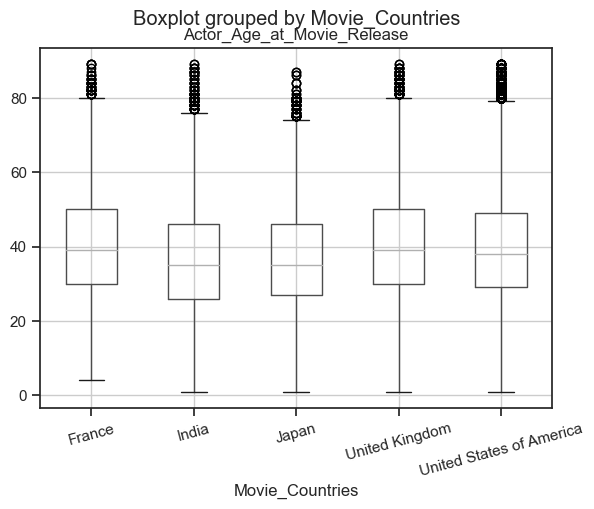

In [77]:
# plot new dataframe
char_age.boxplot(by='Movie_Countries', column='Actor_Age_at_Movie_Release', rot=15)

Whereas in the 50's the USA, UK and France had a similar age of movie actors (~ 39 years), Japan and India had younger actors. With a rather strong decline in the 60's in France, France and Japan show a trend towards older actors in movies. In general the range of actors' ages is low in the USA and UK compared to the other three countries.

C:\Users\Tim\AppData\Local\Temp\ipykernel_26952\211678920.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.lineplot(data=char_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)


[Text(0.5, 1.0, 'Age Distribution over the Decades')]

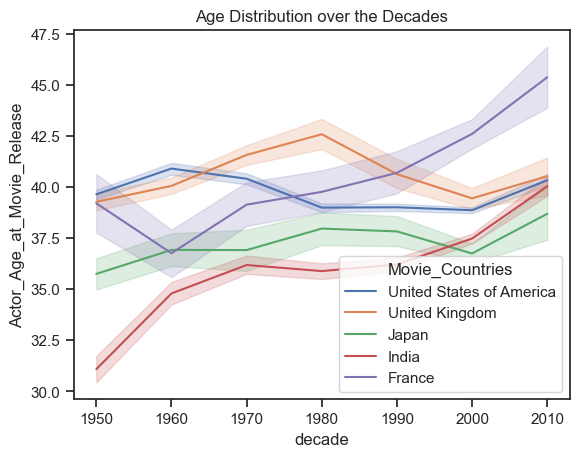

In [78]:
# compare over decades
# CI of 95 % was added
g = sns.lineplot(data=char_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)
g.set(title='Age Distribution over the Decades')

Now we want to check possible correlations between age and movie country / decade. Age is a continuous variable whereas movie country and decade are categorical variables. To check the correlation between these variables, we need to check if assumptions for parametric tests are fulfilled.

In [79]:
# normal distribution
diagnostic.kstest_normal(char_age.Actor_Age_at_Movie_Release.values, dist = 'norm')

(0.06144985313465812, 0.0009999999999998899)

In [80]:
# exponential distribution
diagnostic.kstest_normal(char_age.Actor_Age_at_Movie_Release.values, dist = 'exp')

(0.3446134840891383, 0.0009999999999998899)

The p-value for both null hypotheses that the data comes from a normal or exponential distribution is below 0.05. Thus, we reject both hypotheses. Therefore, we use non-parametric methods to check for correlations.
A proper test for a continuous outcome with more than two categorical predictors is the Kruskal-Wallis-Test.

In [81]:
# split data into countries
age_fr, age_jp, age_in, age_uk,\
age_us = features.country_split(char_age, 'Actor_Age_at_Movie_Release')

stats.kruskal(age_fr, age_jp, age_in, age_uk, age_us)

KruskalResult(statistic=1286.2497071021623, pvalue=3.187094821422093e-277)

The correlation between movie countries and the actors' age is high with a value of 1286.25, positive and significant (p-value << 0.05).

In [82]:
# split into decades
groups_dec = []
for d in char_age.decade.unique():
    groups_dec.append(char_age[char_age.decade == d].Actor_Age_at_Movie_Release)

In [83]:
# kruskal wallis test
stats.kruskal(*groups_dec)

KruskalResult(statistic=374.29529213288936, pvalue=9.349531799523202e-78)

Decades can also be interpreted as a continuous value. We therefore also use the spearman test. That test shows a small negative but significant correlation.

In [84]:
# spearman test
stats.spearmanr(char_age['Actor_Age_at_Movie_Release'], char_age['decade'])

SpearmanrResult(correlation=-0.012233624366847894, pvalue=1.0228316572097333e-07)

The Kruskal-Wallis correlation between decades and the actors' age is lower than the correlation between movie countries and the actors' age but still high with 374.3, positive and significant.

We will now apply regression to get more insight into the effect of movie countries and the decade the movie was produced in.

In [85]:
# linear regression
mod = smf.ols(formula='Actor_Age_at_Movie_Release ~ Movie_Countries + decade', data=char_age)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     Actor_Age_at_Movie_Release   R-squared:                       0.007
Model:                                    OLS   Adj. R-squared:                  0.007
Method:                         Least Squares   F-statistic:                     253.5
Date:                        Fri, 09 Dec 2022   Prob (F-statistic):          5.56e-271
Time:                                14:41:44   Log-Likelihood:            -7.7282e+05
No. Observations:                      189284   AIC:                         1.546e+06
Df Residuals:                          189278   BIC:                         1.546e+06
Df Model:                                   5                                         
Covariance Type:                    nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------

The coefficients for the movie countries are larger than the coefficient for decades. The movie countries have therefore a larger effect on the age of the actors than the decade. However, the category UK has a p-value larger than 0.05 and the confidence interval includes 0. Being from the UK might not have an effect on the actors' age compared to being from France.
In other words, the France and UK have in average the oldest actors over the observed timeframe. Over the decades the actors in movies got older.

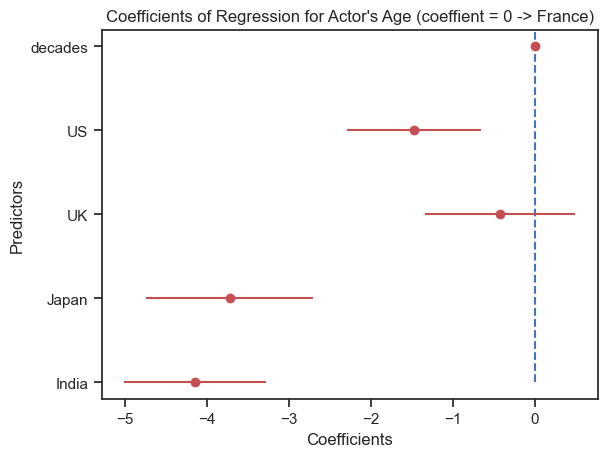

In [86]:
plot.reg_coeff(res, "Coefficients of Regression for Actor's Age (coeffient = 0 -> France)",
              x_ticks=['India', 'Japan', 'UK', 'US', 'decades'])

As a measurement for age diversity a lot of studies use standard deviation. (Source: The (Mis)Use of SD as Age Diversity Measure: Introducing
the Mean SD by De Meulenaere, Biemann & Boone)
Thus, we will stick to this paradigm and also use std as a measure.

In [87]:
# get standard deviation
age_std = char_age.groupby(['Movie_Countries','decade']).Actor_Age_at_Movie_Release.std()

<AxesSubplot: title={'center': 'Std of Age over Decades in the Big 5'}, xlabel='Movie_Countries'>

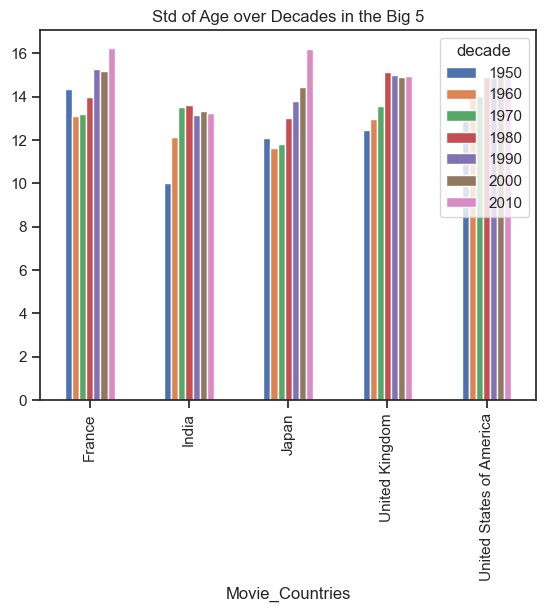

In [88]:
# plot measure
age_std.unstack().plot(kind='bar', title='Std of Age over Decades in the Big 5')

As before we have to neglect the data from 2010 on which is not complete and thus confounds the data. We can see that India, UK and the US have quite constant diversity in actor age since the 70's. France, UK and US have the highest std in age, i.e. the highest age diversity with Japan closing in.

In [89]:
# standard deviation over decades
age_std_decade = char_age.groupby('decade').Actor_Age_at_Movie_Release.std()
stats.spearmanr(age_std_decade, [1950, 1960, 1970, 1980, 1990, 2000, 2010])

SpearmanrResult(correlation=0.9285714285714288, pvalue=0.0025194724037946874)

In [90]:
# standard deviation over countries
age_std_countries = char_age.groupby('Movie_Countries').Actor_Age_at_Movie_Release.std()
stats.kruskal(*age_std_countries)

KruskalResult(statistic=4.0, pvalue=0.40600584970983794)

There is a significant but small positive correlation between decade and the actors age diversity. We cannot reject the null hypothesis that there is no significant relationship between movie countries and age diversity as the p-value is not lower than 0.05.

In [91]:
# create DataFrame for Linear Regression
age_diversity = load.std_full(age_std)

In [92]:
# Linear regression
mod = smf.ols(formula='std ~ countries + decade', data=age_diversity)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    std   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     18.36
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           3.32e-08
Time:                        14:41:44   Log-Likelihood:                -34.903
No. Observations:                  35   AIC:                             81.81
Df Residuals:                      29   BIC:                             91.14
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -78.5973     12

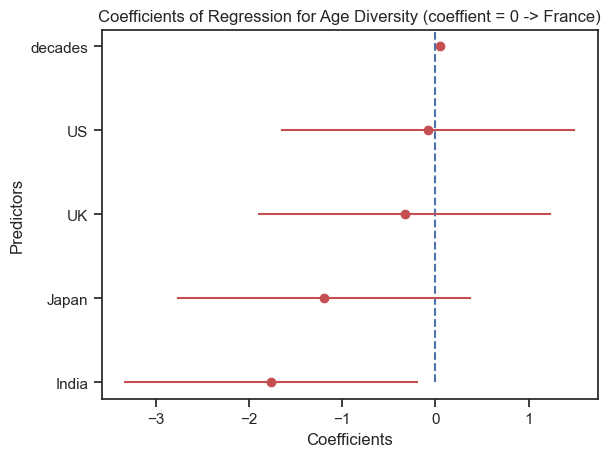

In [93]:
plot.reg_coeff(res, "Coefficients of Regression for Age Diversity (coeffient = 0 -> France)",
              x_ticks=['India', 'Japan', 'UK', 'US', 'decades'])

The regression shows that the effect of countries on the age diversity can be higher than the effect of time but is not necessarily. India for example has a higher effect whereas an origin from the other countries does not imply higher effects, as the confidence interval includes zero.

##### 4.2 Gender

Except for India there is a trend towards more actresses in movies. Only India shows a trend towards more male actors. However, India had the highest ratio in the 50's. In none of the countries were as many male as female actors in 2013.

[Text(0.5, 1.0, 'Gender Ratio over Decades in different Countries')]

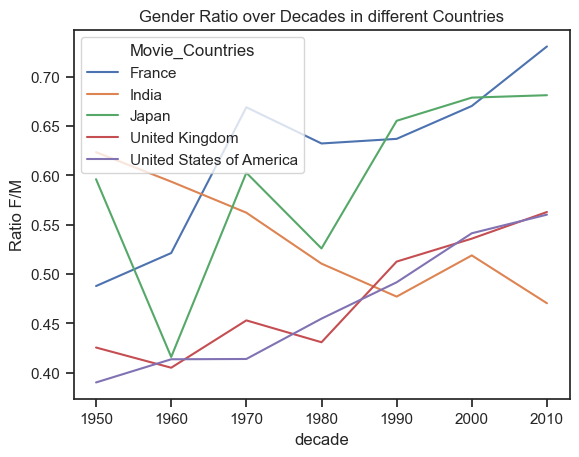

In [94]:
# plot new dataframe
g = sns.lineplot(data=df_gender_ratio, x='decade', y='Ratio F/M', hue='Movie_Countries')
g.set(title='Gender Ratio over Decades in different Countries')

As we did for age, we will examine the correlations of movie countries / decades with the actors' gender. Instead of a continuous outcome variable we have a categorical one, gender. We therefore choose the Pearson Chi-Square test for examination of correlation with movie countries and the logistic regression for correlation with decades.

The null hypothesis is: "The variables do not have a significant relation."

More information about the chi-square test can be found under: 
https://www.geeksforgeeks.org/python-pearsons-chi-square-test/

In [95]:
# create contingency table
observed = load.contingency_table(char_gender)

# apply chi squared test
stat, p, dof, expected = stats.chi2_contingency(observed)
print(f'statistic = {stat}, p-value = {p}')

statistic = 229.9760618509781, p-value = 1.3358135972063752e-48


Since the p-value is below 0.05 the null hypothesis is rejected, i.e. the gender is correlated with the movie country.

In [96]:
# Logistic regression
mod = smf.logit(formula='Actor_Gender_F ~ decade', data=char_gender)
res = mod.fit()
print(res.summary())
print(f'p-value: {res.pvalues["decade"]}')

Optimization terminated successfully.
         Current function value: 0.635686
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         Actor_Gender_F   No. Observations:               223812
Model:                          Logit   Df Residuals:                   223810
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                0.001311
Time:                        14:41:46   Log-Likelihood:            -1.4227e+05
converged:                       True   LL-Null:                   -1.4246e+05
Covariance Type:            nonrobust   LLR p-value:                 3.341e-83
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.5281      0.511    -20.590      0.000     -11.530      -9.526
decade         0.0050      0.

There is a positive correlation between decade and the actor's gender being female.

In [97]:
mod = smf.logit(formula='Actor_Gender_F ~ Movie_Countries + decade', data=char_gender)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.635222
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         Actor_Gender_F   No. Observations:               223812
Model:                          Logit   Df Residuals:                   223806
Method:                           MLE   Df Model:                            5
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                0.002040
Time:                        14:41:48   Log-Likelihood:            -1.4217e+05
converged:                       True   LL-Null:                   -1.4246e+05
Covariance Type:            nonrobust   LLR p-value:                2.230e-123
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

The effect being from a certain country has most of times a higher impact than the decade on the gender of an actor. Japans confidence interval includes zero and contains positive and negative coefficients. The coefficient of the other countries are negative where as the coefficient for the decade as a predictor is positive. This shows, that compared to France the other countries (except for Japan) have less female actors. Furthermore, the decade increases the number of female actors, i.e. the later the movie was produced, the more probable it is to have more female actors being part of it.

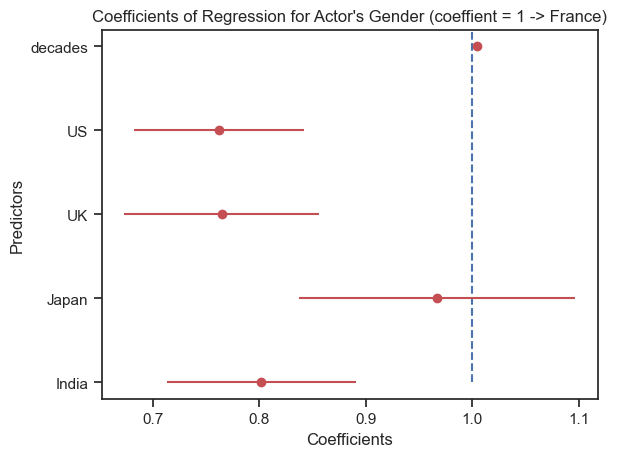

In [98]:
plot.reg_coeff(res, "Coefficients of Regression for Actor's Gender (coeffient = 1 -> France)", 
               x_ticks=['India', 'Japan', 'UK', 'US', 'decades'], log=True)

We will now compare the age between male and female actors in the different countries.
In average female actors are much younger (33.82 +/- 13.9) than male actors (41.55 +/- 13.94).

In [99]:
# use gender as additional information
# assign data to male/female
female_age, male_age = load.indicator_mf(char_age)

In [100]:
female_age.Actor_Age_at_Movie_Release.describe()

count    62511.000000
mean        33.823807
std         13.901891
min          1.000000
25%         24.000000
50%         31.000000
75%         41.000000
max         89.000000
Name: Actor_Age_at_Movie_Release, dtype: float64

In [101]:
male_age.Actor_Age_at_Movie_Release.describe()

count    125823.000000
mean         41.546490
std          13.937652
min           1.000000
25%          31.000000
50%          40.000000
75%          51.000000
max          89.000000
Name: Actor_Age_at_Movie_Release, dtype: float64

France has in average the oldest actresses whereas India has the youngest. The male actors are in every country around the same age.

In [102]:
aggregate.stats_age_by_country(female_age)

,count,mean,std,min,25%,50%,75%,max
Movie_Countries,,,,,,,,
France,1890.0,36.614815,14.913436,5.0,26.0,33.0,44.0,89.0
India,11184.0,28.854793,11.361938,1.0,22.0,26.0,33.0,89.0
Japan,2969.0,31.818121,12.759857,1.0,23.0,29.0,38.0,86.0
United Kingdom,5440.0,35.981066,14.458219,2.0,25.0,32.0,44.0,89.0
United States of America,41028.0,34.908867,14.155075,1.0,25.0,32.0,42.0,89.0


In [103]:
aggregate.stats_age_by_country(male_age)

,count,mean,std,min,25%,50%,75%,max
Movie_Countries,,,,,,,,
France,2937.0,43.556691,14.037038,4.0,33.0,42.0,53.0,89.0
India,20291.0,41.051550,12.254879,1.0,32.0,40.0,49.0,89.0
Japan,4916.0,40.414565,13.168855,3.0,31.0,39.0,49.0,87.0
United Kingdom,12141.0,42.328391,13.169950,1.0,33.0,41.0,51.0,89.0
United States of America,85538.0,41.548949,14.436784,1.0,31.0,40.0,51.0,89.0


C:\Users\Tim\AppData\Local\Temp\ipykernel_26952\2386693275.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.lineplot(data=female_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)


[Text(0.5, 1.0, 'Distribution of Age of Actresses over Decades')]

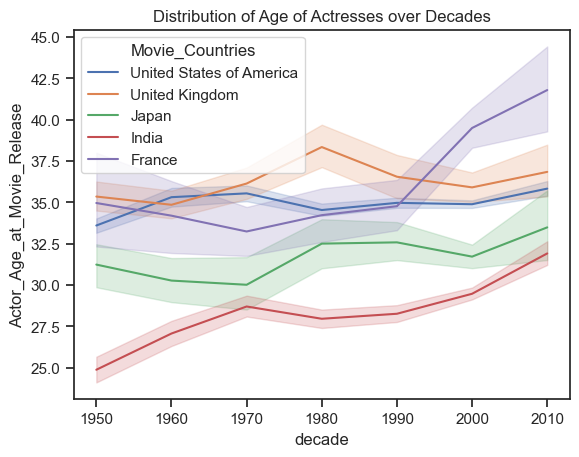

In [104]:
# Age of women in movie industry in different countries
# CI of 95 % was added
g = sns.lineplot(data=female_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)
g.set(title='Distribution of Age of Actresses over Decades')

C:\Users\Tim\AppData\Local\Temp\ipykernel_26952\1495814536.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.lineplot(data=male_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)


[Text(0.5, 1.0, 'Distribution of Age of Male Actors over Decades')]

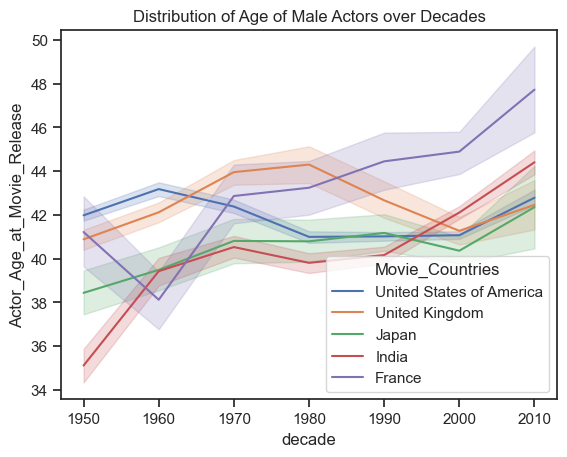

In [105]:
# Age of men in movie industry in different countries
# CI of 95 % was added
g = sns.lineplot(data=male_age, x="decade", y="Actor_Age_at_Movie_Release", hue="Movie_Countries", ci=95)
g.set(title='Distribution of Age of Male Actors over Decades')

Let's check for correlation between gender and age. It would be interesting to examine the impact on the gender from the age of an actor and the additional predictors such as movie country and decade.

In [106]:
# get indicator variable
new_char_age = pd.get_dummies(char_age, columns=['Actor_Gender'])

In [107]:
# apply logistic regression as a test statistic
mod = smf.logit(formula='Actor_Gender_F ~ Actor_Age_at_Movie_Release', data=new_char_age)
res = mod.fit()
print(res.summary())
print(f'p-value: {res.pvalues["Actor_Age_at_Movie_Release"]}')

Optimization terminated successfully.
         Current function value: 0.600791
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         Actor_Gender_F   No. Observations:               189284
Model:                          Logit   Df Residuals:                   189282
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                 0.05291
Time:                        14:41:54   Log-Likelihood:            -1.1372e+05
converged:                       True   LL-Null:                   -1.2007e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.8478      0.015     56.476      0.000      

There is a negative significant correlation between the actor's age and the gender. The older the person is the more likely that person is to be male.

In [108]:
mod = smf.logit(formula='Actor_Gender_F ~ Actor_Age_at_Movie_Release \
              + Movie_Countries + decade', data=new_char_age)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.599146
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         Actor_Gender_F   No. Observations:               189284
Model:                          Logit   Df Residuals:                   189277
Method:                           MLE   Df Model:                            6
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                 0.05550
Time:                        14:41:56   Log-Likelihood:            -1.1341e+05
converged:                       True   LL-Null:                   -1.2007e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

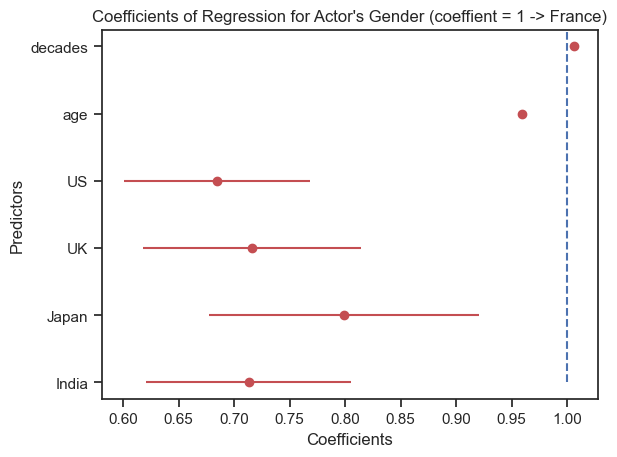

In [109]:
plot.reg_coeff(res, "Coefficients of Regression for Actor's Gender (coeffient = 1 -> France)",
         x_ticks=['India', 'Japan', 'UK', 'US', 'age', 'decades'], log=True)

As before, only the decades have a positive impact on the actor's gender being female. The older the actor the more likely the actor is to be male. The origin of the movie being from US, UK, Japan and India increases the probability that the actor is male as well.

##### Ethnicity

The number of different ethnicities has risen over the decades. Since we only have data until 2013, the decade of 2010's is underpresented and therefore lower than the 2000's.

<AxesSubplot: title={'center': 'Number of Different Ethnicities over Decades in the Big 5'}, xlabel='Movie_Countries'>

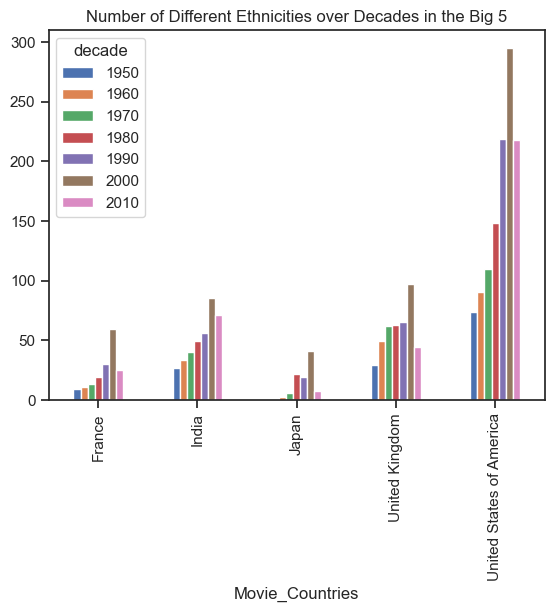

In [110]:
# plot number of ethnicities
count_ethnic.unstack().plot(kind='bar', title='Number of Different Ethnicities over Decades in the Big 5')

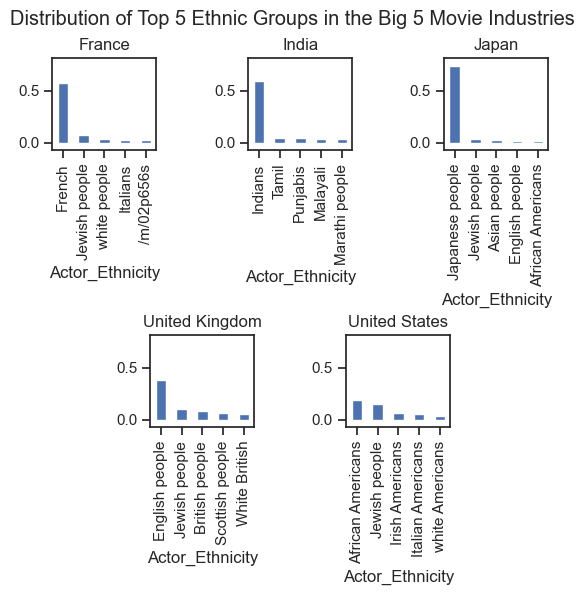

In [111]:
# plot Distribution of Top 5 Ethnic Groups in the Big 5 Movie Industries
plot.ethnic_ratio_countries(top_perc)

As can be seen in the diagrams it is not very easy to examine the diversity in ethnicities. For example the US have in their top 5 ethnic groups a much lower ratio but that is due to the division of the group of Americans into African Americans, Irish Americans etc. The UK have English people, British people, Scottish people etc. as ethnic groups listed, but they are all native on that island. We can therefore try to evaluate the correlation between the number of ethnic groups or the ratio with the decades / movie countries, however the result might not be a very good indicator for diversity. Thus, ethnicity as a diversity measure is to be neglected.

In [112]:
num_ethnic_countries = char_ethnicity.groupby('Movie_Countries').Actor_Ethnicity.nunique()
num_ethnic_countries

Movie_Countries
France                       88
India                       109
Japan                        50
United Kingdom              157
United States of America    339
Name: Actor_Ethnicity, dtype: int64

In [113]:
num_ethnic_decade = char_ethnicity.groupby('decade').Actor_Ethnicity.nunique()
num_ethnic_decade

decade
1950    105
1960    128
1970    154
1980    202
1990    279
2000    363
2010    278
Name: Actor_Ethnicity, dtype: int64

In general the number of ethnicities is increasing with time. But this could be because of more actors as the production of movies increased. Similar to before we will now calculate a ratio. The ratio between number of ethnic groups and number actors is not proper as the number of ethnic groups is finite and grows slower whereas the number of actors could grow much faster. We will therefore lean on a measure similar to the ethno-lingustic fractionalization index from the book: New Approaches to the Dynamics, Measurement and Economic Implications of Ethnic Diversity by Philipp Kolo.

We take the ratio between the number of ethnic groups and the total number of ethnic groups which was 650 according to a survey from 2002.

Source: https://www.washingtonpost.com/news/worldviews/wp/2013/05/16/a-revealing-map-of-the-worlds-most-and-least-ethnically-diverse-countries/

In [114]:
ratio_countries = num_ethnic_countries / 650
ratio_decades = num_ethnic_decade / 650

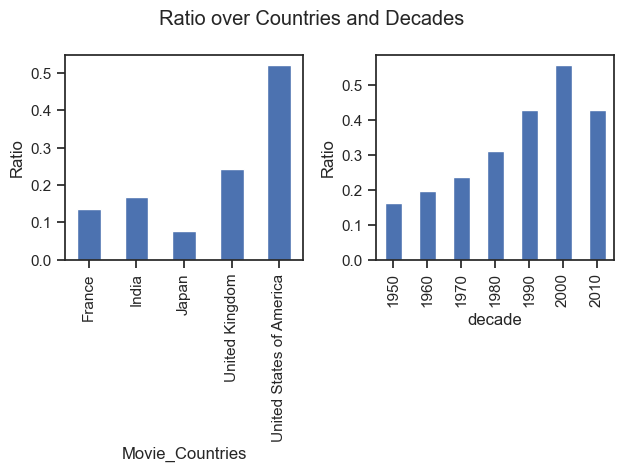

In [115]:
plot.countries_decades(ratio_countries, ratio_decades, 'Ratio')

As mentioned before the data for 2010 is not representative as we miss over 7 years of data from that epoch. Thus, the ratio is increasing with time. The US have the highest ratio whereas Japan has the lowest rate. But as the following graphic shows, the ratio has increased over time in every country.

<AxesSubplot: title={'center': 'Ethnicities over Decades in the Big 5'}, xlabel='Movie_Countries'>

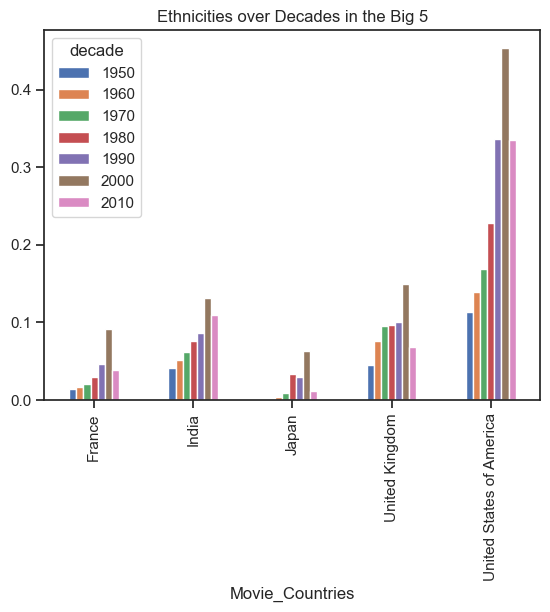

In [116]:
ratio_ethnic = count_ethnic / 650
ratio_ethnic.unstack().plot(kind='bar', title='Ethnicities over Decades in the Big 5')

##### Height

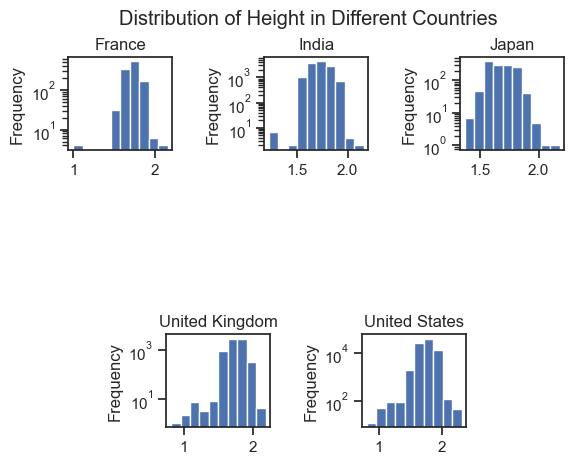

In [117]:
# Histogram Height
plot.distributions_countries(char_height, 'Actor_Height', "Distribution of Height in Different Countries", logy=True)

<AxesSubplot: title={'center': 'Actor_Height'}, xlabel='Movie_Countries'>

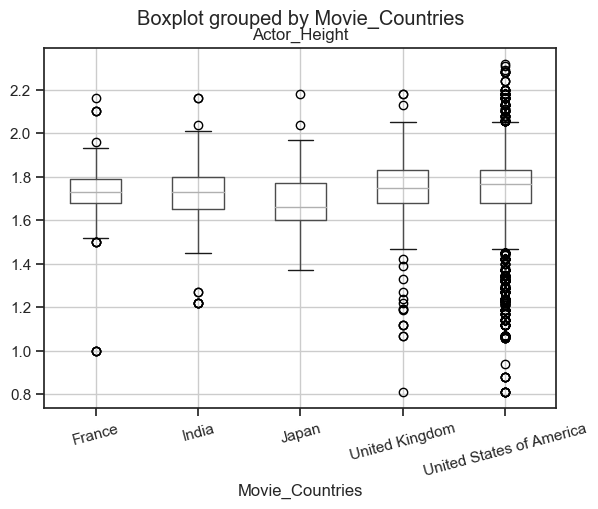

In [118]:
# plot data
char_height.boxplot(by='Movie_Countries', column='Actor_Height', rot=15)

C:\Users\Tim\AppData\Local\Temp\ipykernel_26952\1790738641.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=char_height, x="decade", y="Actor_Height", hue="Movie_Countries", ci=95)


<AxesSubplot: xlabel='decade', ylabel='Actor_Height'>

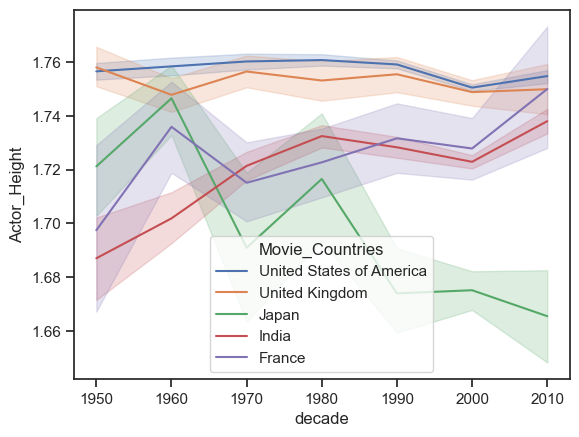

In [119]:
# check height over decades
# CI of 95 % was added
sns.lineplot(data=char_height, x="decade", y="Actor_Height", hue="Movie_Countries", ci=95)

The UK and the USA had both very tall and short male actors over the time of 1950-2013. France and India started including very short male actors from the 2000's. Tall people were always part of movies, however, short men were not included in Japan. Short-grown women were not part of movies until the 80's.

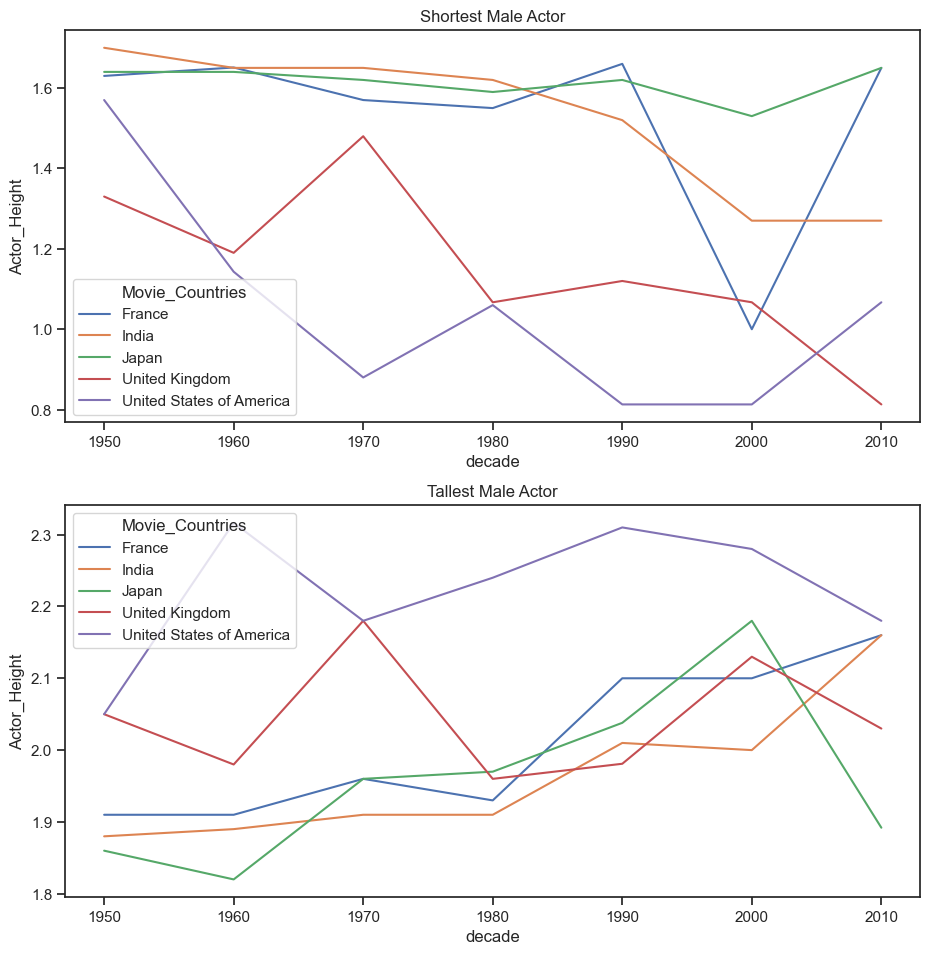

In [120]:
# check male height over decades
plot.height_decades(min_max_mh, 'Male')

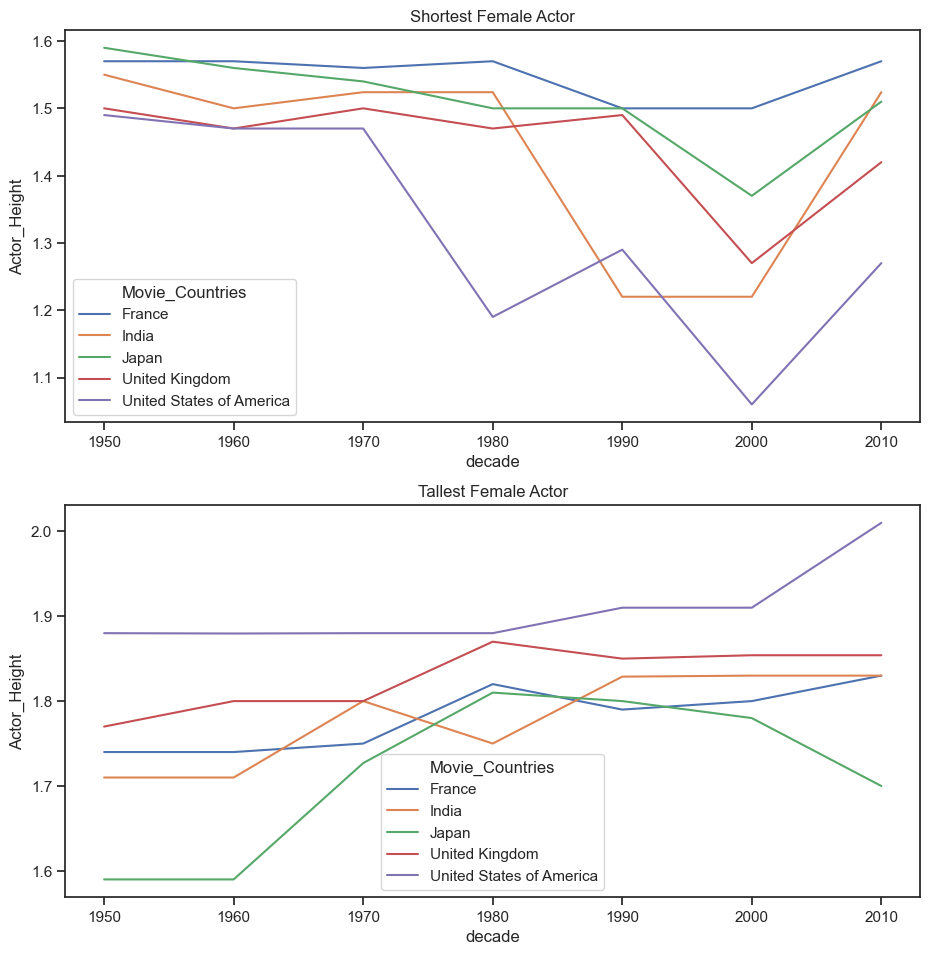

In [121]:
# check female height over decades
plot.height_decades(min_max_fh, 'Female')

We will now check correlations between height and movie countries / decades.
As height is a continuous number we will apply the same procedure as for age.

In [122]:
diagnostic.kstest_normal(char_height.Actor_Height.values, dist = 'norm')

(0.05308186411303417, 0.0009999999999998899)

In [123]:
diagnostic.kstest_normal(char_height.Actor_Height.values, dist = 'exp')

(0.573218357052881, 0.0009999999999998899)

The p-value for both null hypotheses that the data comes from a normal or exponential distribution is below 0.05. Thus, we reject both hypotheses. Therefore, we use non-parametric methods to check for correlations.
We will apply the Kruskal-Wallis-Test.

In [124]:
# split data into countries
height_fr, height_jp, height_in, height_uk,\
height_us = features.country_split(char_height, 'Actor_Height')

stats.kruskal(height_fr, height_jp, height_in, height_uk, height_us)

KruskalResult(statistic=1614.7020285269375, pvalue=0.0)

The correlation between movie countries and the actors' height is high with a value of 1614.7, positive and significant (p-value << 0.05).

In [125]:
# split data into decades
groups_dec = []
for d in char_height.decade.unique():
    groups_dec.append(char_height[char_height.decade == d].Actor_Height)

In [126]:
stats.kruskal(*groups_dec)

KruskalResult(statistic=192.14962906314813, pvalue=8.881113617899785e-39)

Decades can also be interpreted as a continuous value. We therefore also use the spearman test. That test shows a small negative but significant correlation.

In [127]:
stats.spearmanr(char_height['Actor_Height'], char_height['decade'])

SpearmanrResult(correlation=-0.027902696371627927, pvalue=7.906857596623622e-19)

Like in the case of age, we also see a correlation between the actors' heights and movie countries / decades. Let's check the results of a regression.

In [128]:
# Linear regression
mod = smf.ols(formula='Actor_Height ~ Movie_Countries + decade', data=char_height)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Actor_Height   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     308.3
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:42:04   Log-Likelihood:                 84079.
No. Observations:              100820   AIC:                        -1.681e+05
Df Residuals:                  100814   BIC:                        -1.681e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

As can be seen from the coefficients the development of height did not change over the decades. Actors in movies from India and France are similar in height, whereas actors in japanese movies are in average less tall than french actors and actors in movies from UK and US are taller. The effect from the movies origin has a higher impact than the decade it was produced in.

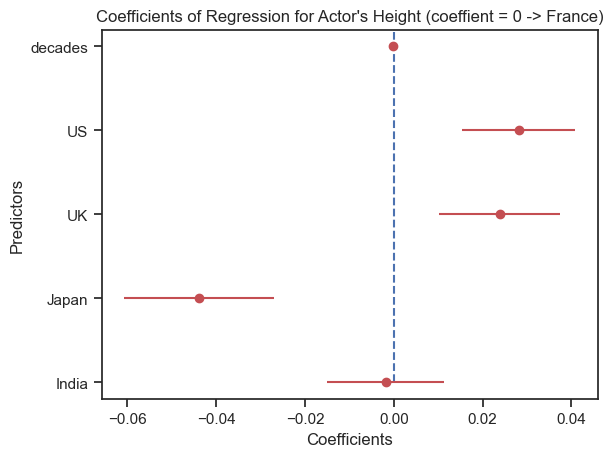

In [129]:
plot.reg_coeff(res, "Coefficients of Regression for Actor's Height (coeffient = 0 -> France)",
         x_ticks=['India', 'Japan', 'UK', 'US', 'decades'])

As this information is not different from what we could read in the boxplots, we will use as a new metric the difference between the tallest and shortest person.

In [130]:
# get span of heights over countries
height_countries = char_height.groupby('Movie_Countries').Actor_Height.max() - char_height.groupby('Movie_Countries').Actor_Height.min()
height_countries

Movie_Countries
France                      1.16000
India                       0.94000
Japan                       0.81000
United Kingdom              1.36700
United States of America    1.50348
Name: Actor_Height, dtype: float64

In [131]:
# get span of heights over decades
height_decade = char_height.groupby('decade').Actor_Height.max() - char_height.groupby('decade').Actor_Height.min()
height_decade

decade
1950    0.72000
1960    1.17348
1970    1.30000
1980    1.18000
1990    1.49700
2000    1.46700
2010    1.36700
Name: Actor_Height, dtype: float64

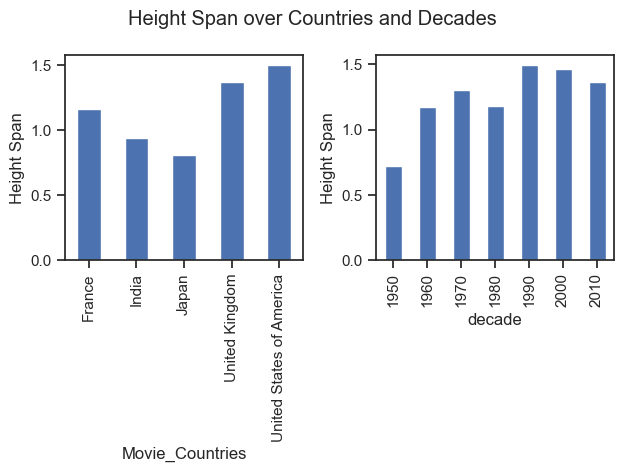

In [132]:
plot.countries_decades(height_countries, height_decade, 'Height Span')

In the observed timeframe Japan has the lowest height span and thus less diversed actors w.r.t. height whereas the UK and US have the highest span. Over the decades the span was at a minimum in the 50's and increased strongly after that. Since the 90's the span is at around 1.40 - 1.50 m.

<AxesSubplot: title={'center': 'Height Span over Decades in the Big 5'}, xlabel='Movie_Countries'>

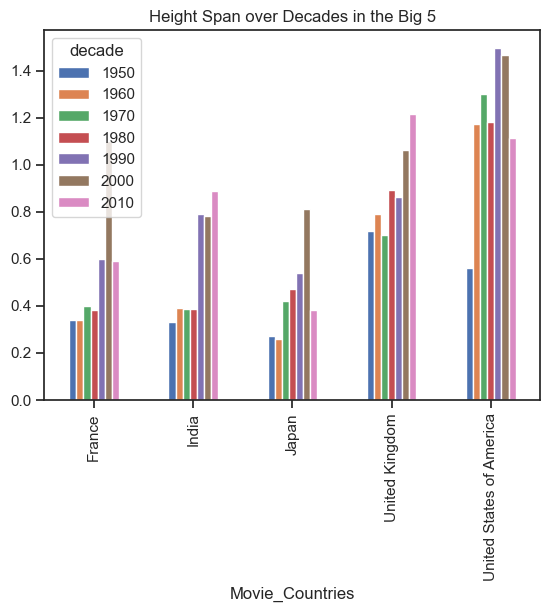

In [133]:
# Height over decades in different countries
height = char_height.groupby(['Movie_Countries', 'decade']).Actor_Height.max() - char_height.groupby(['Movie_Countries', 'decade']).Actor_Height.min()
height.unstack().plot(kind='bar', title='Height Span over Decades in the Big 5')

The graphic shows that the diversity of height has only increased so much in the 50's because there were more movies in the US with more different sized actors. In France, India and Japan the increase happened 40 to 50 years later.

##### Combination of the four metrics for diversity

We will now combine the four metrics for diversity in age, gender, ethnicity and height into one. This will include:
- standard deviation of age
- gender ratio
- ratio number of ethnic groups / total number of ethnic groups
- height span

As we have different amount of data for these measures, we will weight the measures according to the provided amount of data.

In [134]:
# get data quantity
num_data_age = len(char_age)
num_data_gender = len(char_gender)
num_data_ethnic = len(char_ethnicity)
num_data_height = len(char_height)
num_total = num_data_age + num_data_gender + num_data_ethnic + num_data_height

# calculate weights
w_age = num_data_age / num_total
w_gender = num_data_gender / num_total
w_ethnic = num_data_ethnic / num_total
w_height = num_data_height / num_total

In [135]:
# calculate diversity for each country
div_fr = w_age * age_std.France + w_gender * df_gender_ratio.unstack()['Ratio F/M'].France + \
    w_ethnic * ratio_ethnic.France + w_height * height.France
div_in = w_age * age_std.India + w_gender * df_gender_ratio.unstack()['Ratio F/M'].India + \
    w_ethnic * ratio_ethnic.India + w_height * height.India
div_jp = w_age * age_std.Japan + w_gender * df_gender_ratio.unstack()['Ratio F/M'].Japan + \
    w_ethnic * ratio_ethnic.Japan + w_height * height.Japan
div_uk = w_age * age_std['United Kingdom'] + w_gender * df_gender_ratio.unstack()['Ratio F/M']['United Kingdom'] + \
    w_ethnic * ratio_ethnic['United Kingdom'] + w_height * height['United Kingdom']
div_us = w_age * age_std['United States of America'] + w_gender * df_gender_ratio.unstack()['Ratio F/M']['United States of America'] + \
    w_ethnic * ratio_ethnic['United States of America'] + w_height * height['United States of America']

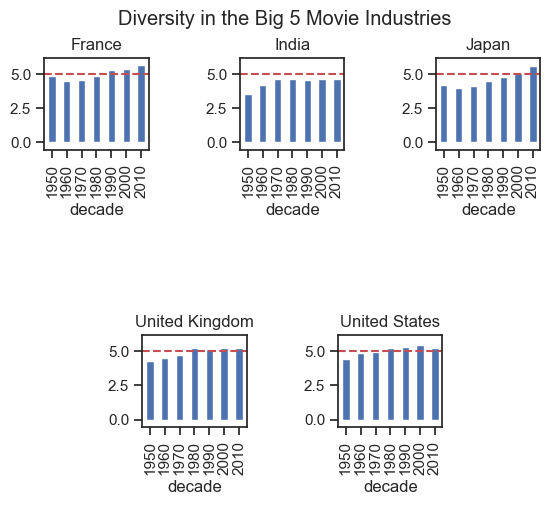

In [136]:
# plot development of diversity in the top 5 movie industries
plot.diversity(div_fr, div_in, div_jp, div_uk, div_us)

Discarding the data from 2010 the US have the highest recent diversity in movies followed by France. India has the lowest diversity which stagnated since the 70's. Japan and France show a trend towards more diversity.

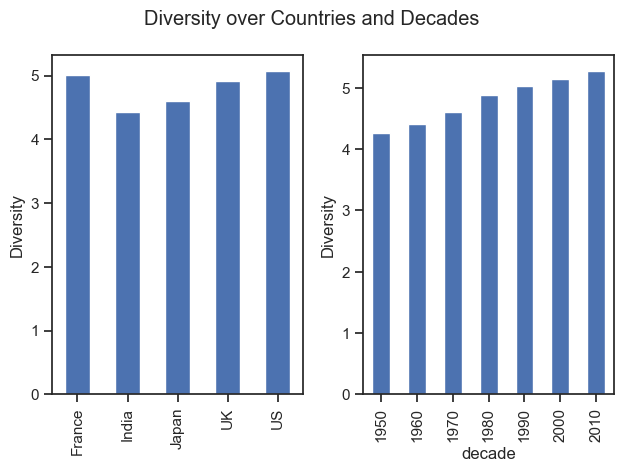

In [137]:
decade_div = (div_fr + div_in + div_jp + div_uk + div_us) / 5
country_div = pd.concat((div_fr, div_in, div_jp, div_uk, div_us),
                              axis=1)
country_div.columns = ['France', 'India', 'Japan', 'UK', 'US']
country_div = country_div.mean()

plot.countries_decades(country_div, decade_div, 'Diversity')

France and US have the highest diversity in the given time period whereas India has the lowest. Over the decades the diversity has increased.

In [139]:
# create dataframe for application of linear regression
total_div = load.diversity_full(div_fr, div_in, div_jp, div_uk, div_us)

In [140]:
mod = smf.ols(formula='diversity ~ countries + decade', data=total_div)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              diversity   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     24.77
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           1.19e-09
Time:                        14:42:18   Log-Likelihood:                 5.1226
No. Observations:                  35   AIC:                             1.755
Df Residuals:                      29   BIC:                             11.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -29.7855      3

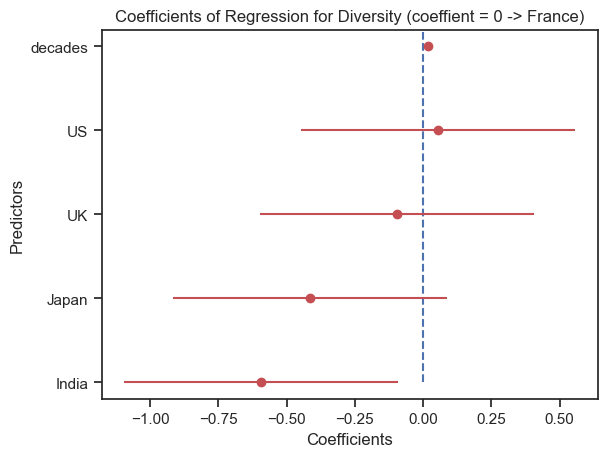

In [141]:
plot.reg_coeff(res, "Coefficients of Regression for Diversity (coeffient = 0 -> France)",
         x_ticks=['India', 'Japan', 'UK', 'US', 'decades'])

The regression shows only significant effect for India, Japan and decades as predictors. We can see that Japan's confidence interval includes zero, i.e. it might not effect the diversity score. India as a predictor reduces the diversity score whereas decades increases it.

## References

[1] “Global Box Office Down 72%, Digital Leads Home Entertainment in 2020,” Boxoffice, Mar. 26, 2021. https://www.boxofficepro.com/global-box-office-down-72-digital-leads-home-entertainment-in-2020/ (accessed Nov. 16, 2022).